<h1 style="font-size:300%">Movies review sentiment analysis</h1>

Viktor Doychev, student AI4-RB03

This notebook demonstrates how to do sentiment analysis on movie reviews.

First, we load the necessary libraries for this project. Then the current version of each of the libraries is shown.  

In [1]:
import os
import sklearn
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn import preprocessing

print("scikit-learn version:", sklearn.__version__)     # 1.2.1
print("pandas version:", pd.__version__)            # 2.0.0
print("seaborn version:", seaborn.__version__)          # 0.12.2

scikit-learn version: 1.2.1
pandas version: 2.0.0
seaborn version: 0.12.2


# 📃 Data requirements 
There are several important requirements that should be met so the data is applicable for this project. 
- All datasets must be open source
- The datasets with reviews must be about movie reviews.
- The datasets for movie reviews must have text column where is the text of the review and label column where it can be found the sentiment of the review. Any other columns with data related to the domain is welcome.
- The number of positive and negative reviews should be roughly equal so there is no bias towards the category with more data samples.
- The overall number of reviews should be above 5000 rows
- The dataset with the spam reviews can be also from any other platform where reviews or comments can be written. The reason for that is because everywhere the spam is the same and it is not something that changes with the domain.
- The dataset with spam reviews must contain one column with the text of the spam review and one column with the label of the review. Any additional data related to the domain is welcome.
- The dataset with spam reviews can be with little data samples (anomalies like this are something normal and not in big numbers). This would be considered when training the model.



# 📦 Data provisioning
After trying various  of datasets, the conclusion that we should merge several of them in one was made. The reason behind this decision is because the models were overfitting and they needed more data in order to improve the overall accuracy. In this notebook we are going to use 4 movie review datasets and 1 spam dataset to reach the end-goal of this project. 
The first dataset we are going to use in this notebook is [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/). It consists of 25,000 movie reviews for training, and 25,000 for testing but we are going to use all of them for the training. The dataset should be downloaded and then imported in the notebook. The structure of the dataset after downloading it is the following: there are two folders(training and testing). In each of these two folders there are two more folders(pos and neg). In each of pos and neg folders there are text files which contain the review(one review per text file). We will use the directories where the folders with movie reviews are stored. Then we create empty lists for positive and negative reviews. After that we are going to loop through pos and neg folders in both training and testing folders and adds it in the empty lists, depending on whether it is a positive or negative review. Then we will create a list that will contain both positive and negative lists. After that we create list which contains the following labels - 1 for positive reviews and  for negative reviews. Finally, we create dataframe called df_1 with two columns: `text` column for the reviews and `tag_id` for the labels and we check the end-result.

In [2]:
movie_reviews_dir_train = 'C:/Users/Admin/Desktop/aclImdb/train' # directory where the movie reviews for training are stored.
movie_reviews_dir_test = 'C:/Users/Admin/Desktop/aclImdb/test/'  # directory where the movie reviews for testing are stored.

pos_reviews = []    # empty list for positive reviews
for filename in os.listdir(os.path.join(movie_reviews_dir_train, 'pos')):       #loop through all files in pos folder in train folder
    with open(os.path.join(movie_reviews_dir_train, 'pos', filename), 'r', encoding='utf-8') as f:
        review = f.read()
        pos_reviews.append(review)
for filename in os.listdir(os.path.join(movie_reviews_dir_test, 'pos')):        #loop through all files in pos folder in test folder
    with open(os.path.join(movie_reviews_dir_test, 'pos', filename), 'r', encoding='utf-8') as f:
        review = f.read()
        pos_reviews.append(review)

neg_reviews = []    #empty list for negative reviews
for filename in os.listdir(os.path.join(movie_reviews_dir_train, 'neg')):   #loop through all files in neg folder in train folder
    with open(os.path.join(movie_reviews_dir_train, 'neg', filename), 'r', encoding='utf-8') as f:
        review = f.read()
        neg_reviews.append(review)
for filename in os.listdir(os.path.join(movie_reviews_dir_test, 'neg')):    #loop through all files in neg folder in test folder
    with open(os.path.join(movie_reviews_dir_test, 'neg', filename), 'r', encoding='utf-8') as f:
        review = f.read()
        neg_reviews.append(review)

reviews = pos_reviews + neg_reviews     

labels = [1] * len(pos_reviews) + [0] * len(neg_reviews)    #list that has a value of 1 for each review in pos_reviews and a value of 0 for each review in neg_reviews.

df_1 = pd.DataFrame({'text': reviews, 'tag_id': labels})
df_1

,text,tag_id
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1
...,...,...
49995,I occasionally let my kids watch this garbage ...,0
49996,When all we have anymore is pretty much realit...,0
49997,The basic genre is a thriller intercut with an...,0
49998,Four things intrigued me as to this film - fir...,0


We will create column called `tag` which will contain the lable representing the sentiment of the review and then `tag_id` column is dropped. The reason for that is because the datasets from below that we are going to use soon don't have `tag_id` column but they have column like `tag`. 

In [3]:
df_1['tag'] = df_1['tag_id'].apply(lambda x: 'neg' if x == 0 else 'pos')
df_1 = df_1.drop(columns='tag_id')
df_1

,text,tag
0,Bromwell High is a cartoon comedy. It ran at t...,pos
1,Homelessness (or Houselessness as George Carli...,pos
2,Brilliant over-acting by Lesley Ann Warren. Be...,pos
3,This is easily the most underrated film inn th...,pos
4,This is not the typical Mel Brooks film. It wa...,pos
...,...,...
49995,I occasionally let my kids watch this garbage ...,neg
49996,When all we have anymore is pretty much realit...,neg
49997,The basic genre is a thriller intercut with an...,neg
49998,Four things intrigued me as to this film - fir...,neg


The next dataset we are going to use is [Movie reviews dataset](https://www.kaggle.com/datasets/nltkdata/movie-review?select=movie_review.csv).
The data will be loaded using the `pandas read_csv` function. The data consists of 64 720 rows and 6 columns.

In [4]:
df_2 = pd.read_csv('C:/Users/Admin/Desktop/Personal_challenge/Movie_reviews_dataset/movie_review.csv')
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64720 entries, 0 to 64719
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   fold_id  64720 non-null  int64 
 1   cv_tag   64720 non-null  object
 2   html_id  64720 non-null  int64 
 3   sent_id  64720 non-null  int64 
 4   text     64720 non-null  object
 5   tag      64720 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.0+ MB


Let's check a sample to spot more details for this dataset.

In [5]:
df_2

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos
...,...,...,...,...,...,...
64715,9,cv999,14636,20,that lack of inspiration can be traced back to...,neg
64716,9,cv999,14636,21,like too many of the skits on the current inca...,neg
64717,9,cv999,14636,22,"after watching one of the "" roxbury "" skits on...",neg
64718,9,cv999,14636,23,"bump unsuspecting women , and . . . that's all .",neg


We can see that the first 4 columns doesn't represent anything important for our end-goal which is sentiment anlysis. Let's drop them and check the dataset again.

In [6]:
df_2 = df_2.drop(columns=['fold_id', 'cv_tag', 'html_id', 'sent_id'])
df_2.sample(10)

,text,tag
29941,one point of contention might be a lackluster ...,pos
24525,but regardless of what decade it transports us...,pos
30989,the angels here are stark and believable .,pos
48473,"both characters are protagonists , but it's ha...",neg
20200,"he's been playing for a while , and more than ...",pos
60537,"with the millenium just around the corner , ho...",neg
15622,"there are no easy answers to be found within ""...",pos
62653,and the audience also has to suffer bobcat gol...,neg
34041,watching connery and fishburne bump heads for ...,neg
53551,"wait a minute "" .",neg


The third dataset we are going to use is [IMDB Large Movie Reviews Sentiment Dataset](https://www.kaggle.com/datasets/jcblaise/imdb-sentiments). We will use again the the `pandas read_csv` function. This dataset consists of 2 columns(`text` for the reviews and `sentiment` for the sentiment of the reviews) and 25 000 rows.

In [7]:
df_3 = pd.read_csv('C:/Users/Admin/Desktop/New folder/train.csv')
df_3

,text,sentiment
0,For a movie that gets no respect there sure ar...,0
1,Bizarre horror movie filled with famous faces ...,0
2,"A solid, if unremarkable film. Matthau, as Ein...",0
3,It's a strange feeling to sit alone in a theat...,0
4,"You probably all already know this by now, but...",0
...,...,...
24995,"My comments may be a bit of a spoiler, for wha...",1
24996,"The ""saucy"" misadventures of four au pairs who...",1
24997,"Oh, those Italians! Assuming that movies about...",1
24998,Eight academy nominations? It's beyond belief....,1


As we saw above there are three problems. The first one is the name of the column `sentiment` and this is why we are going to rename it.The second problem is that the negative and positive numerical values in `sentiment` column are different compared to the other datasets(in this dataset 0 is representing positive and 1 is representing negative). To deal with that we have to replace 0 with 1 and 1 with 0.The third problem is that the values are numerical but they shouldn't be. That's why we are going to create a new column called `tag` and replace 0 with `neg` and 1 with `pos`.

In [8]:
df_3 = df_3.rename(columns={'sentiment':'tag_id'})
df_3['tag_id'] = df_3['tag_id'].replace({0:1, 1:0})
df_3['tag'] = df_3['tag_id'].replace({0:'neg', 1: 'pos'})
df_3 = df_3.drop(columns='tag_id')
df_3

,text,tag
0,For a movie that gets no respect there sure ar...,pos
1,Bizarre horror movie filled with famous faces ...,pos
2,"A solid, if unremarkable film. Matthau, as Ein...",pos
3,It's a strange feeling to sit alone in a theat...,pos
4,"You probably all already know this by now, but...",pos
...,...,...
24995,"My comments may be a bit of a spoiler, for wha...",neg
24996,"The ""saucy"" misadventures of four au pairs who...",neg
24997,"Oh, those Italians! Assuming that movies about...",neg
24998,Eight academy nominations? It's beyond belief....,neg


The fourth dataset for movie reviews is [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). We will use again the the `pandas read_csv` function. This dataset consists of 2 columns(`review` for the reviews and `sentiment` for the sentiment of the reviews) and 50 000 rows.

In [9]:
df_4 = pd.read_csv('C:/Users/Admin/Desktop/New folder/IMDB Dataset.csv')
df_4

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


We have two small problems with this dataset. The first one is the naming of the columns(`sentiment` should be `tag` and `review` should be `text`). The second problem is that insted of `positive` it should be `pos` and insted of `negative` is should be `neg`. Let's fix this.

In [10]:
df_4 = df_4.rename(columns={'sentiment':'tag', 'review':'text'})
df_4['tag'] = df_4['tag'].replace({'positive': 'pos', 'negative':'neg'})
df_4

,text,tag
0,One of the other reviewers has mentioned that ...,pos
1,A wonderful little production. <br /><br />The...,pos
2,I thought this was a wonderful way to spend ti...,pos
3,Basically there's a family where a little boy ...,neg
4,"Petter Mattei's ""Love in the Time of Money"" is...",pos
...,...,...
49995,I thought this movie did a down right good job...,pos
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",neg
49997,I am a Catholic taught in parochial elementary...,neg
49998,I'm going to have to disagree with the previou...,neg


The last dataset we are doing to use is[YouTube Spam Collection Data Set](https://www.kaggle.com/datasets/lakshmi25npathi/images). It consists of 5 columns and 1956 rows. 

In [11]:
spam_dataset_path = 'C:/Users/Admin/Desktop/Personal_challenge/youtube-spam-collection-v1'
spam_dataset_files = os.listdir(spam_dataset_path)
spam_dfs = []

for file in spam_dataset_files:
    spam_df = pd.read_csv(os.path.join(spam_dataset_path, file))
    spam_dfs.append(spam_df)

spam_df = pd.concat(spam_dfs, ignore_index=True)
spam_df


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
...,...,...,...,...,...
1951,_2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0
1952,_2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0
1953,_2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs,jeffrey jules,2013-07-13T12:09:31.188000,wow,0
1954,_2viQ_Qnc6_yBt8UGMWyg3vh0PulTqcqyQtdE7d4Fl0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0


There are several things we want to fix in this dataset. The first thing we will do is to drop the columns `COMMENT_ID`, `AUTHOR` and `DATE`. The reason for that is that they are not needed for the use case of this project which is sentiment anlysis. The second thing we will do is to rename columns `CONTENT` to `text` and `CLASS` to `tag`. The third thing we will do is to get all values that have 1 in `tag` column because the values with 0 in `tag` column are not spam and we are interested only in the spam reviews. The last thing we will do is to change 1 to `spam` so later we will be able to encode it in the preprocessing phase.

In [12]:
spam_df = spam_df.drop(columns=['COMMENT_ID', 'AUTHOR', 'DATE'])
spam_df = spam_df.rename(columns={'CONTENT': 'text', 'CLASS': 'tag'})
spam_df = spam_df[spam_df['tag'] != 0]
spam_df['tag'] = spam_df['tag'].replace({1:'spam'})
spam_df

,text,tag
0,"Huh, anyway check out this you[tube] channel: ...",spam
1,Hey guys check out my new channel and our firs...,spam
2,just for test I have to say murdev.com,spam
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,spam
4,watch?v=vtaRGgvGtWQ Check this out .﻿,spam
...,...,...
1943,********OMG Facebook is OLD! Check out ------...,spam
1944,Hey Music Fans I really appreciate all of you ...,spam
1945,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,spam
1946,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,spam


It is time to merge our dataset. We will first merge the first two in dataframe called `df`. Let's check the result.

In [13]:
df = pd.concat([df_1, df_2])
df

,text,tag
0,Bromwell High is a cartoon comedy. It ran at t...,pos
1,Homelessness (or Houselessness as George Carli...,pos
2,Brilliant over-acting by Lesley Ann Warren. Be...,pos
3,This is easily the most underrated film inn th...,pos
4,This is not the typical Mel Brooks film. It wa...,pos
...,...,...
64715,that lack of inspiration can be traced back to...,neg
64716,like too many of the skits on the current inca...,neg
64717,"after watching one of the "" roxbury "" skits on...",neg
64718,"bump unsuspecting women , and . . . that's all .",neg


Now we will merge the third dataset with `df` dataset.

In [14]:
df = pd.concat([df, df_3])
df

,text,tag
0,Bromwell High is a cartoon comedy. It ran at t...,pos
1,Homelessness (or Houselessness as George Carli...,pos
2,Brilliant over-acting by Lesley Ann Warren. Be...,pos
3,This is easily the most underrated film inn th...,pos
4,This is not the typical Mel Brooks film. It wa...,pos
...,...,...
24995,"My comments may be a bit of a spoiler, for wha...",neg
24996,"The ""saucy"" misadventures of four au pairs who...",neg
24997,"Oh, those Italians! Assuming that movies about...",neg
24998,Eight academy nominations? It's beyond belief....,neg


We will do the same for the last dataset for movie reviews.

In [15]:
df = pd.concat([df, df_4])
df

,text,tag
0,Bromwell High is a cartoon comedy. It ran at t...,pos
1,Homelessness (or Houselessness as George Carli...,pos
2,Brilliant over-acting by Lesley Ann Warren. Be...,pos
3,This is easily the most underrated film inn th...,pos
4,This is not the typical Mel Brooks film. It wa...,pos
...,...,...
49995,I thought this movie did a down right good job...,pos
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",neg
49997,I am a Catholic taught in parochial elementary...,neg
49998,I'm going to have to disagree with the previou...,neg


And now is time to add the last dataset for spam. In the end, we have dataset with 2 columns and 190725 rows.

In [16]:
df = pd.concat([df, spam_df])
df

,text,tag
0,Bromwell High is a cartoon comedy. It ran at t...,pos
1,Homelessness (or Houselessness as George Carli...,pos
2,Brilliant over-acting by Lesley Ann Warren. Be...,pos
3,This is easily the most underrated film inn th...,pos
4,This is not the typical Mel Brooks film. It wa...,pos
...,...,...
1943,********OMG Facebook is OLD! Check out ------...,spam
1944,Hey Music Fans I really appreciate all of you ...,spam
1945,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,spam
1946,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,spam


# 🔎 Data understanding
The aim of this part of the notebook is to get more in-depth infortmation about the dataset we have.

Let's check if there are any empty values in the dataset.

In [17]:
isna_sum = df.isna().sum().sum()
notna_sum = df.notna().sum().sum()

print('NA values in total:',isna_sum)
print('Non NA values in total:',notna_sum)

NA values in total: 0
Non NA values in total: 381450


Important step is to check if there are enough data samples from each category. Also we want to have roughly equal amount of samples per category in order to prevent bias in the model. Let's first check the ratio per category. We can see that spam class has 1%(we will deal with that later) but the other 2 classes are roughly equal.

array([<AxesSubplot: ylabel='text'>], dtype=object)

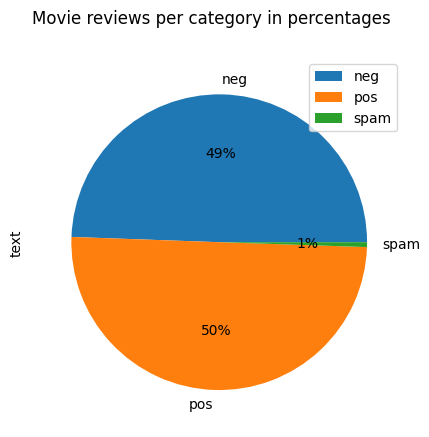

In [18]:
review_category_info = df.groupby(['tag']).count().plot(kind='pie', title='Movie reviews per category in percentages', autopct='%1.0f%%', subplots=True)
review_category_info

Now, let's check the exact numbers per category. The exact numbers per category is displayed over the bars.

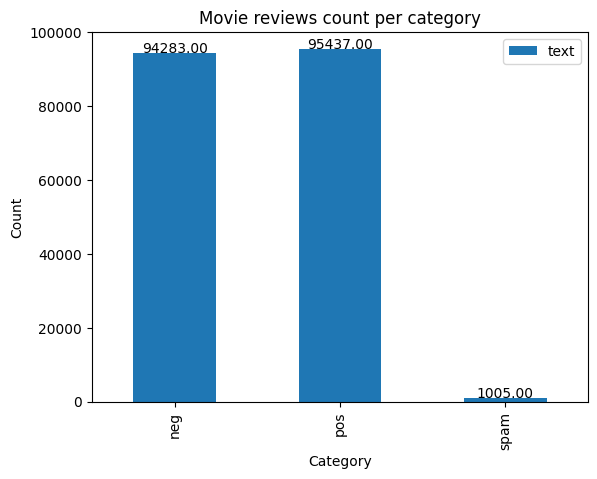

In [19]:
counts = df.groupby(['tag']).count()
counts.plot(kind='bar', xlabel='Category', ylim=([0,100000]), ylabel='Count', title='Movie reviews count per category')
# Adding the values of the categories on top of the bars
for i, v in enumerate(counts['text']):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.show()

To see any possible patterns between the emotion in `tag` column and the length of the review from `text` column. From the plot we make conclusions that there are more positive reviews than negative ones in the short rande of the reviews.

C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\822282082.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews['text_length'] = positive_reviews['text'].str.len()
C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\822282082.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['text_length'] = negative_reviews['text'].str.len()
C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\822282082.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

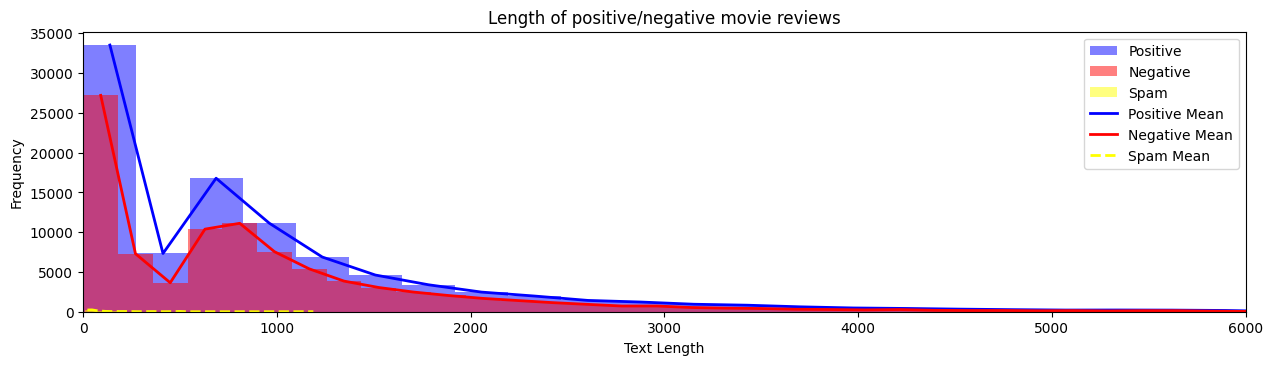

In [20]:
positive_reviews = df[df['tag'] == 'pos']
negative_reviews = df[df['tag'] == 'neg']
spam_reviews = df[df['tag'] == 'spam']

positive_reviews['text_length'] = positive_reviews['text'].str.len()
negative_reviews['text_length'] = negative_reviews['text'].str.len()
spam_reviews['text_length'] = spam_reviews['text'].str.len()

plt.figure(figsize=[15, 8]);
plt.subplot(2,1,1);
plt.hist(positive_reviews['text_length'], bins=50, alpha=0.5, color='blue', label='Positive')

plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Length of positive/negative movie reviews')

plt.subplot(2,1,1);
plt.hist(negative_reviews['text_length'], bins=50, alpha=0.5, color='red', label='Negative')


plt.subplot(2,1,1);
plt.hist(spam_reviews['text_length'], bins=50, alpha=0.5, color='yellow', label='Spam')

plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.xlim(0,6000)

pos_means, pos_edges, _ = plt.hist(positive_reviews['text_length'], bins=50, alpha=0.0)
pos_bins = (pos_edges[:-1] + pos_edges[1:]) / 2
plt.plot(pos_bins, pos_means, label='Positive Mean', color='blue', linewidth=2)

neg_means, neg_edges, _ = plt.hist(negative_reviews['text_length'], bins=50, alpha=0.0)
neg_bins = (neg_edges[:-1] + neg_edges[1:]) / 2
plt.plot(neg_bins, neg_means, label='Negative Mean', color='red', linewidth=2)

spam_means, spam_edges, _ = plt.hist(spam_reviews['text_length'], bins=50, alpha=0.0)
spam_bins = (spam_edges[:-1] + spam_edges[1:]) / 2
plt.plot(spam_bins, spam_means, label='Spam Mean', color='yellow', linestyle='--', linewidth=2)

plt.legend(loc='upper right')

plt.show()

From the above plot, we cannot get information about the length of spam reviews because there aren't that many values that are from spam class compared to the other classes. Let's take a look at the tendancy of the length of spam reviews. We can see that most of spam review tend to be really short(up to 200 characters).

C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\2043369843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_reviews['text_length'] = spam_reviews['text'].str.len()


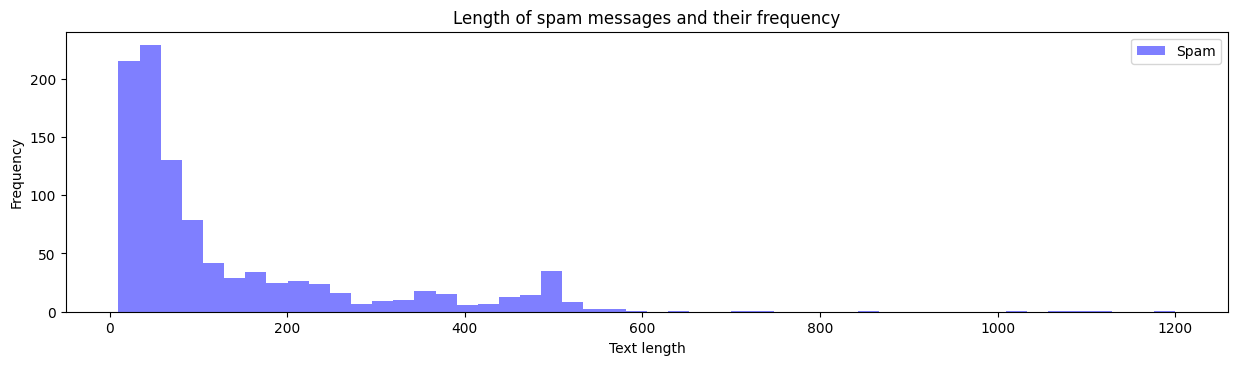

In [21]:
spam_reviews = df[df['tag'] == 'spam']
spam_reviews['text_length'] = spam_reviews['text'].str.len()

plt.figure(figsize=[15, 8]);
plt.subplot(2,1,1);
plt.hist(spam_reviews['text_length'], bins=50, alpha=0.5, color='blue', label='Spam')

plt.legend(loc='upper right')
plt.title('Length of spam messages and their frequency')
plt.xlabel('Text length')
plt.ylabel('Frequency')

plt.show()

To spot the difference in the length of the reviews per class we will plot them. To follow easier the tendancy of the length we will plot a line over the bars. We can see that in the shortest ranges(around up to 50 characters) the negative reviews are the most frequent. However, with increasing the length of the review(from around 50 up to 500 characters) we can see that positive reviews are more frequent to negative ones.

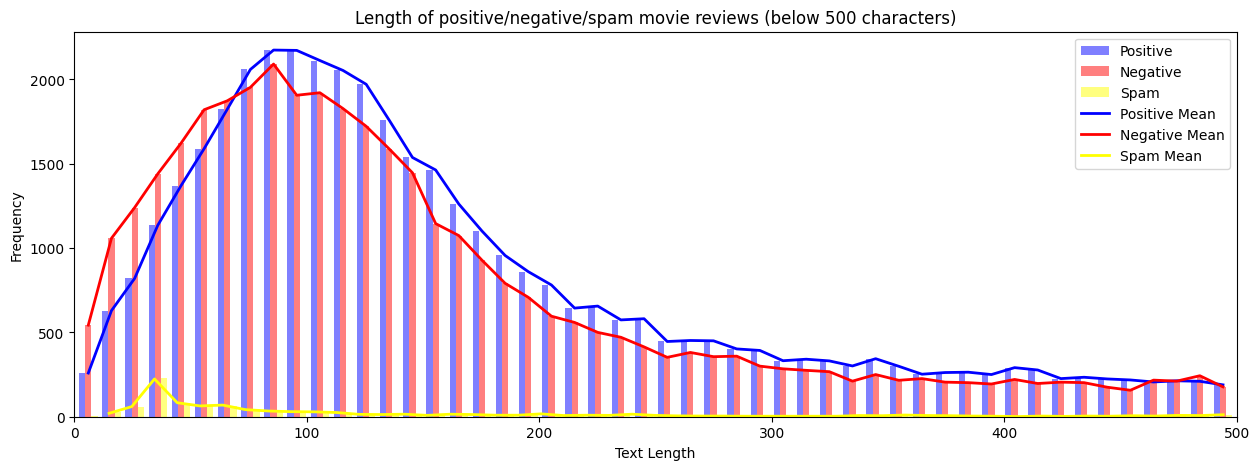

In [22]:
positive_reviews_below_500 = positive_reviews.loc[positive_reviews['text_length'] < 500]
negative_reviews_below_500 = negative_reviews.loc[negative_reviews['text_length'] < 500]
spam_reviews = spam_reviews.loc[spam_reviews['text_length'] < 500] # this is done for presentational purposes only

plt.figure(figsize=[15, 5])

plt.hist([positive_reviews_below_500['text_length'], negative_reviews_below_500['text_length'],spam_reviews['text_length']], bins=50, alpha=0.5, color=['blue', 'red', 'yellow'], label=['Positive', 'Negative', 'Spam'])

pos_means, pos_edges, _ = plt.hist(positive_reviews_below_500['text_length'], bins=50, alpha=0.0)
pos_bins = (pos_edges[:-1] + pos_edges[1:]) / 2
plt.plot(pos_bins, pos_means, label='Positive Mean', color='blue', linewidth=2)

neg_means, neg_edges, _ = plt.hist(negative_reviews_below_500['text_length'], bins=50, alpha=0.0)
neg_bins = (neg_edges[:-1] + neg_edges[1:]) / 2
plt.plot(neg_bins, neg_means, label='Negative Mean', color='red', linewidth=2)

spam_means, spam_edges, _ = plt.hist(spam_reviews['text_length'], bins=50, alpha=0.0)
spam_bins = (spam_edges[:-1] + spam_edges[1:]) / 2
plt.plot(spam_bins, spam_means, label='Spam Mean', color='yellow', linewidth=2)

plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Length of positive/negative/spam movie reviews (below 500 characters)')
plt.legend(loc='upper right')
plt.xlim(0, 500)

plt.show()

#checking more detailed plot to see the pattern in short reviews


To check the tendancy in the length of the reviews when they are medium range, we will make a new plot. The plot will represent the reviews frequency with text length between 500 and 2 000 characters. We can see that both positive and negative are rougly equaly frequent when the review length is around 650-700 characters. However, after that we can notice that negative reviews become a little bit more frequent to positive ones. 

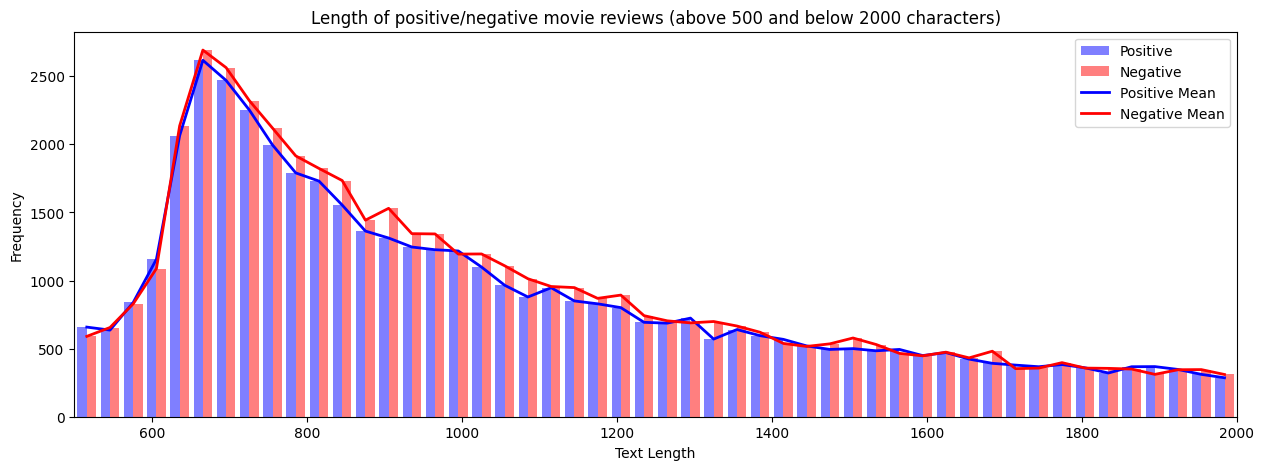

In [23]:
positive_reviews_below_2000 = positive_reviews.loc[(positive_reviews['text_length'] < 2000) & (positive_reviews['text_length'] > 500)]
negative_reviews_below_2000 = negative_reviews.loc[(negative_reviews['text_length'] < 2000) & (negative_reviews['text_length'] > 500)]

plt.figure(figsize=[15, 5])

plt.hist([positive_reviews_below_2000['text_length'], negative_reviews_below_2000['text_length']], bins=50, alpha=0.5, color=['blue', 'red'], label=['Positive', 'Negative'])

pos_means, pos_edges, _ = plt.hist(positive_reviews_below_2000['text_length'], bins=50, alpha=0.0)
pos_bins = (pos_edges[:-1] + pos_edges[1:]) / 2
plt.plot(pos_bins, pos_means, label='Positive Mean', color='blue', linewidth=2)

neg_means, neg_edges, _ = plt.hist(negative_reviews_below_2000['text_length'], bins=50, alpha=0.0)
neg_bins = (neg_edges[:-1] + neg_edges[1:]) / 2
plt.plot(neg_bins, neg_means, label='Negative Mean', color='red', linewidth=2)

plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Length of positive/negative movie reviews (above 500 and below 2000 characters)')
plt.xlim([500,2000])
plt.legend(loc='upper right')

plt.show()

To check the tendancy in the length of the reviews when they are long range, we will make a new plot. The plot will represent the reviews frequency with text length above 2 000 characters. We can see that they are roughly equal but positive reviews tend to be me a little bit more frequent to negative reviews when the text length is above 2 000 characters.

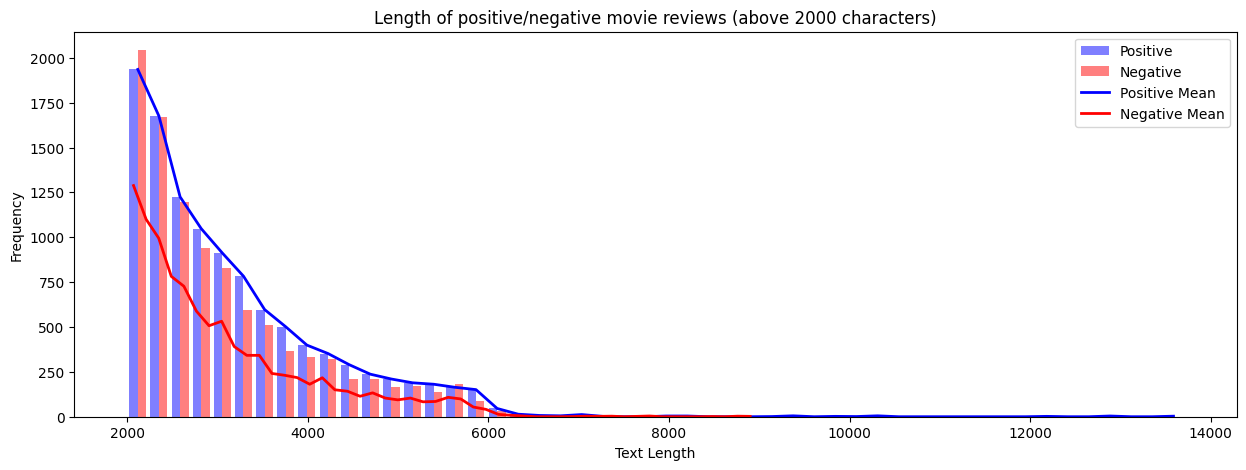

In [24]:
positive_reviews_above_2000 = positive_reviews.loc[positive_reviews['text_length'] > 2000]
negative_reviews_above_2000 = negative_reviews.loc[negative_reviews['text_length'] > 2000]

plt.figure(figsize=[15, 5])

plt.hist([positive_reviews_above_2000['text_length'], negative_reviews_above_2000['text_length']], bins=50, alpha=0.5, color=['blue', 'red'], label=['Positive', 'Negative'])

pos_means, pos_edges, _ = plt.hist(positive_reviews_above_2000['text_length'], bins=50, alpha=0.0)
pos_bins = (pos_edges[:-1] + pos_edges[1:]) / 2
plt.plot(pos_bins, pos_means, label='Positive Mean', color='blue', linewidth=2)

neg_means, neg_edges, _ = plt.hist(negative_reviews_above_2000['text_length'], bins=50, alpha=0.0)
neg_bins = (neg_edges[:-1] + neg_edges[1:]) / 2
plt.plot(neg_bins, neg_means, label='Negative Mean', color='red', linewidth=2)

plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Length of positive/negative movie reviews (above 2000 characters)')
plt.legend(loc='upper right')

plt.show()

From the plot above we can't get clear insight on the tencancy of the length of reviews per class with length above 6 000 characters. From this plot we can spot that positive reviews are the most frequent ones when the length of the review is above 6 000 characters. 

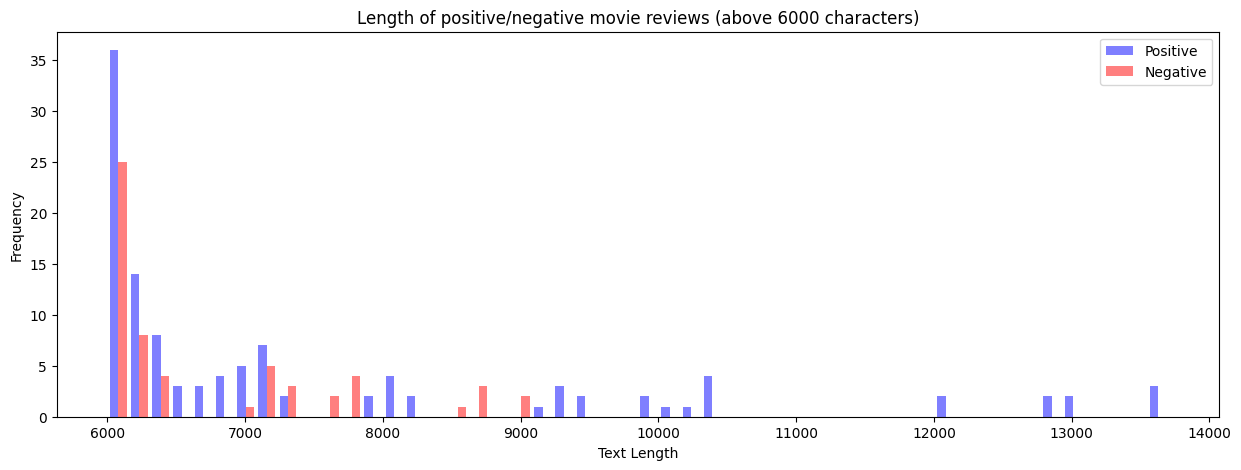

In [25]:
positive_reviews_above_6000 = positive_reviews.loc[positive_reviews['text_length'] > 6000]
negative_reviews_above_6000 = negative_reviews.loc[negative_reviews['text_length'] > 6000]

plt.figure(figsize=[15, 5])

plt.hist([positive_reviews_above_6000['text_length'], negative_reviews_above_6000['text_length']], bins=50, alpha=0.5, color=['blue', 'red'], label=['Positive', 'Negative'])

plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Length of positive/negative movie reviews (above 6000 characters)')
plt.legend(loc='upper right')

plt.show()
# checking if there is pattern in longer reviews

From the previous plot, we got the impression that positive reviews tend to be more frequent in the short and long ranges of the text length compared to negative reviews. However, we spotted that spam reviews are really short and most of them are with length less than 500 characters.To spot the difference in length, the length of all 3 categories will be ploted and also their mean. This way we will be able to spot the the tendancy of the length per class and how it changes when the review is longer.
From the plot below we can make the conclusion that the spam reviews tend to be the shortest ones. When it comes to posiive and negative reviews we say that positive are more frequent in short and long ranges while negative are more frequent in the middle length.

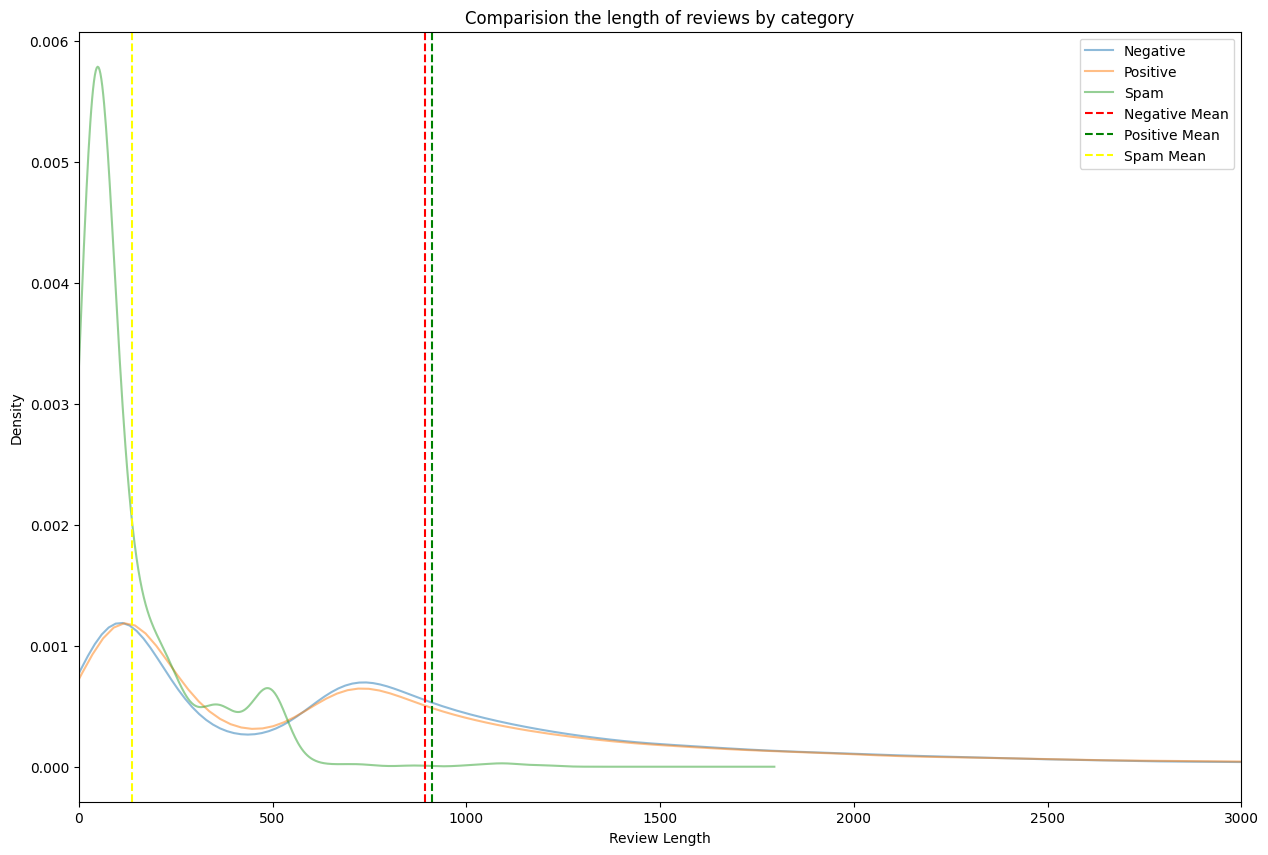

In [26]:
negative_reviews = df[df['tag'] == 'neg']
positive_reviews = df[df['tag'] == 'pos']
spam_reviews = df[df['tag'] == 'spam']

negative_reviews_text_lengths = negative_reviews['text'].apply(len)
positive_reviews_text_lengths = positive_reviews['text'].apply(len)
spam_reviews_text_lengths = spam_reviews['text'].apply(len)

negative_reviews_mean_length = negative_reviews_text_lengths.mean()
positive_reviews_mean_length = positive_reviews_text_lengths.mean()
spam_reviews_mean_length = spam_reviews_text_lengths.mean()

fig, ax = plt.subplots(figsize=(15, 10))  # set figsize to (width, height) in inches

negative_reviews_text_lengths.plot(kind='density', xlim=[0,3000], alpha=0.5, label='Negative')
positive_reviews_text_lengths.plot(kind='density', xlim=[0,3000],alpha=0.5, label='Positive')
spam_reviews_text_lengths.plot(kind='density', xlim=[0, 3000], alpha=0.5, label='Spam')

plt.axvline(x=negative_reviews_mean_length, color='red', linestyle='--', label='Negative Mean')
plt.axvline(x=positive_reviews_mean_length, color='green', linestyle='--', label='Positive Mean')
plt.axvline(x=spam_reviews_mean_length, color='yellow', linestyle='--', label='Spam Mean')

plt.xlabel('Review Length')
plt.ylabel('Density')
plt.title('Comparision the length of reviews by category')
plt.legend()

plt.show()

Let's check also the mean length the reviews per category. We san make the conlusion that the shortest are spam reviews, followed by negative and positive.

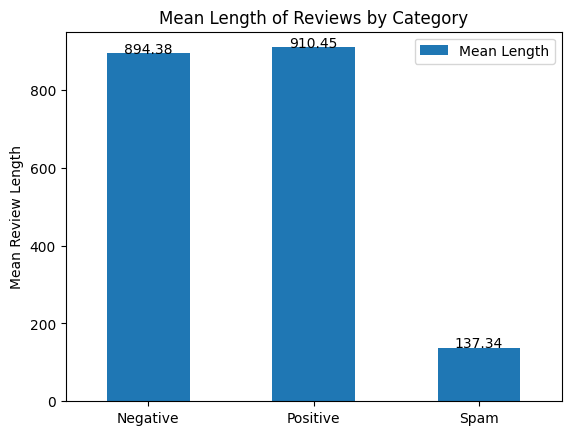

In [27]:
mean_lengths = pd.DataFrame({'Mean Length': [negative_reviews_mean_length, positive_reviews_mean_length, spam_reviews_mean_length]},
                            index=['Negative', 'Positive', 'Spam'])
mean_lengths.plot(kind='bar', ylim=([0,950]), rot=0)

for i, v in enumerate(mean_lengths['Mean Length']):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')

plt.title('Mean Length of Reviews by Category')
plt.ylabel('Mean Review Length')
plt.show()

Let's take a look at more detailed information about the categories. 

In [28]:
df[df['tag']=='pos'].describe()

,text,tag
count,95437,95437
unique,64618,1
top,.,pos
freq,45,95437


In [29]:
df[df['tag']=='neg'].describe()

,text,tag
count,94283,94283
unique,63344,1
top,.,neg
freq,78,94283


In [30]:
df[df['tag']=='spam'].describe()

,text,tag
count,1005,1005
unique,841,1
top,Check out this video on YouTube:﻿,spam
freq,97,1005


From the above tables we saw that most frequent review for positive and negative review is just a dot. This is something that should be taken care of later in the data preparation phase but it is important to understand the exact percentage of reviews that are that short(which can mean that there are just punctuation marks which are not useful for the model training).To continue our analysis, first we have to create 3 lists - 1 for negative, 1 for positive and 1 for spam.

In [31]:
negative_reviews = df[df['tag'] == 'neg']
positive_reviews = df[df['tag'] == 'pos']
spam_reviews = df[df['tag'] == 'spam']

After that we will check how frequent are reviews with length below 50 characters. The aim is to make more detailed plot to see the pattern in short reviews.

C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\3763336754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews['text_length'] = positive_reviews['text'].str.len()
C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\3763336754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['text_length'] = negative_reviews['text'].str.len()
C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\3763336754.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

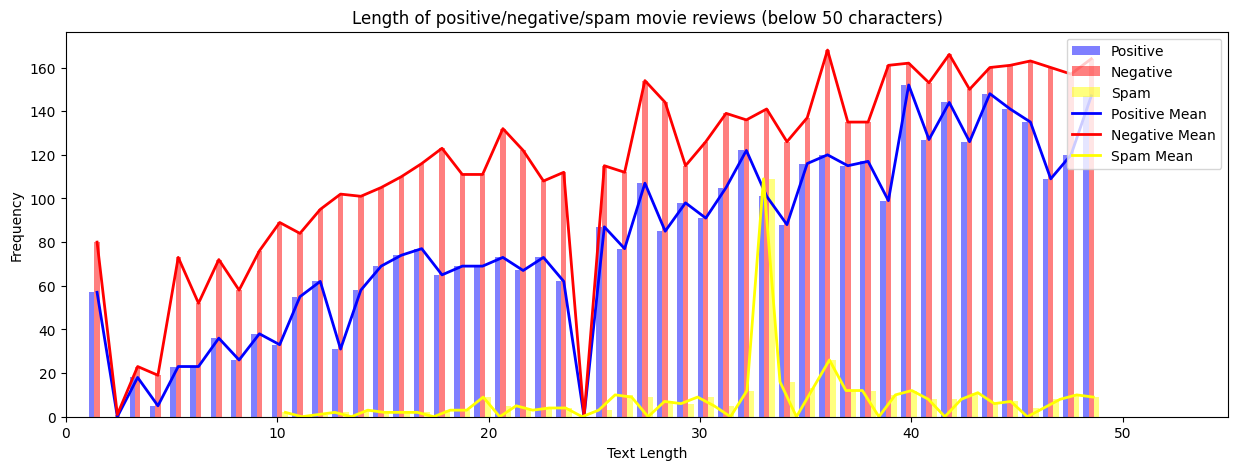

In [32]:
positive_reviews['text_length'] = positive_reviews['text'].str.len()
negative_reviews['text_length'] = negative_reviews['text'].str.len()
spam_reviews['text_length'] = spam_reviews['text'].str.len()

positive_reviews_below_50 = positive_reviews.loc[positive_reviews['text_length'] < 50]
negative_reviews_below_50 = negative_reviews.loc[negative_reviews['text_length'] < 50]
spam_reviews_below_50 = spam_reviews.loc[spam_reviews['text_length'] < 50] # this is done for presentational purposes only

plt.figure(figsize=[15, 5])

plt.hist([positive_reviews_below_50['text_length'], negative_reviews_below_50['text_length'],spam_reviews_below_50['text_length']], bins=50, alpha=0.5, color=['blue', 'red', 'yellow'], label=['Positive', 'Negative', 'Spam'])

pos_means, pos_edges, _ = plt.hist(positive_reviews_below_50['text_length'], bins=50, alpha=0.0)
pos_bins = (pos_edges[:-1] + pos_edges[1:]) / 2
plt.plot(pos_bins, pos_means, label='Positive Mean', color='blue', linewidth=2)

neg_means, neg_edges, _ = plt.hist(negative_reviews_below_50['text_length'], bins=50, alpha=0.0)
neg_bins = (neg_edges[:-1] + neg_edges[1:]) / 2
plt.plot(neg_bins, neg_means, label='Negative Mean', color='red', linewidth=2)

spam_means, spam_edges, _ = plt.hist(spam_reviews_below_50['text_length'], bins=50, alpha=0.0)
spam_bins = (spam_edges[:-1] + spam_edges[1:]) / 2
plt.plot(spam_bins, spam_means, label='Spam Mean', color='yellow', linewidth=2)

plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.xlim([0, 55])
plt.title('Length of positive/negative/spam movie reviews (below 50 characters)')
plt.legend(loc='upper right')
# plt.xlim(0, 500)

plt.show()

#checking more detailed plot to see the pattern in short reviews


From the plot above we can notice that there are reviews which are pretty short. We can spot that spam reviews start from 10 characters length. Moreover, we can see pattern in positive and negative reviews from 10 characters and above(their numbers in frequency start increasing). That is why we are going to check all reviews with length less than 10 characters(in most cases this can't be a meaningful review) and plot their percentage of all reviews in the dataset. 

We can see that the percentages are not big(0% for spam, 0.2% for negative and 0.1% for positive).

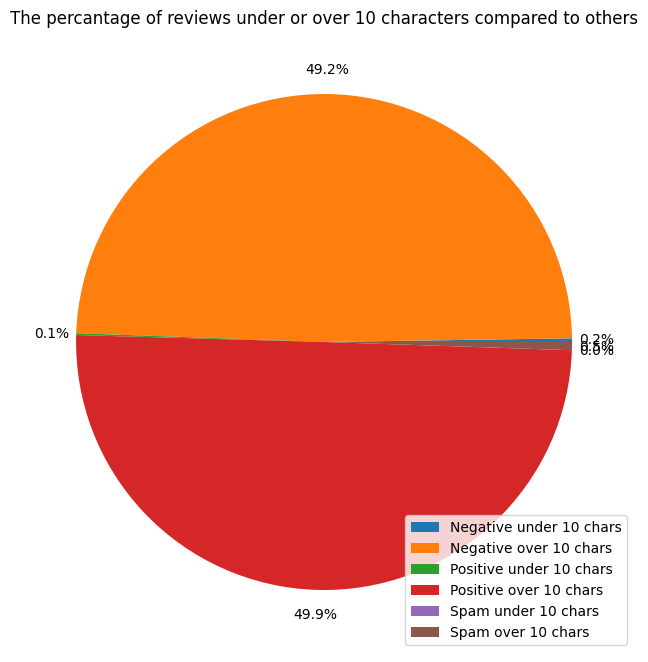

In [33]:
neg_reviews_under_10_char = negative_reviews[negative_reviews_text_lengths < 10]
neg_reviews_under_10_char = neg_reviews_under_10_char['text'].count()
neg_reviews_over_10_char = negative_reviews['text'].count() - neg_reviews_under_10_char

pos_reviews_under_10_char = positive_reviews[positive_reviews_text_lengths < 10]
pos_reviews_under_10_char = pos_reviews_under_10_char['text'].count()
pos_reviews_over_10_char = positive_reviews['text'].count() - pos_reviews_under_10_char

spam_reviews_under_10_char = spam_reviews[spam_reviews_text_lengths < 10]
spam_reviews_under_10_char = spam_reviews_under_10_char['text'].count()
spam_reviews_over_10_char = spam_reviews['text'].count() - spam_reviews_under_10_char

counts = [neg_reviews_under_10_char, neg_reviews_over_10_char, pos_reviews_under_10_char, pos_reviews_over_10_char,spam_reviews_under_10_char,spam_reviews_over_10_char]
labels = ['Negative under 10 chars','Negative over 10 chars', 'Positive under 10 chars', 'Positive over 10 chars', 'Spam under 10 chars', 'Spam over 10 chars']

fig, ax = plt.subplots(figsize=(8, 10))
ax.pie(counts, autopct='%1.1f%%',
       pctdistance=1.10, labeldistance=.4)
plt.legend(labels, loc='lower right')
plt.title('The percantage of reviews under or over 10 characters compared to others')

plt.show()

We can dig deeper into the information and examine the most frequent words in negative, positive and spam reviews. This way we will be able to spot any anomalies in the data. 

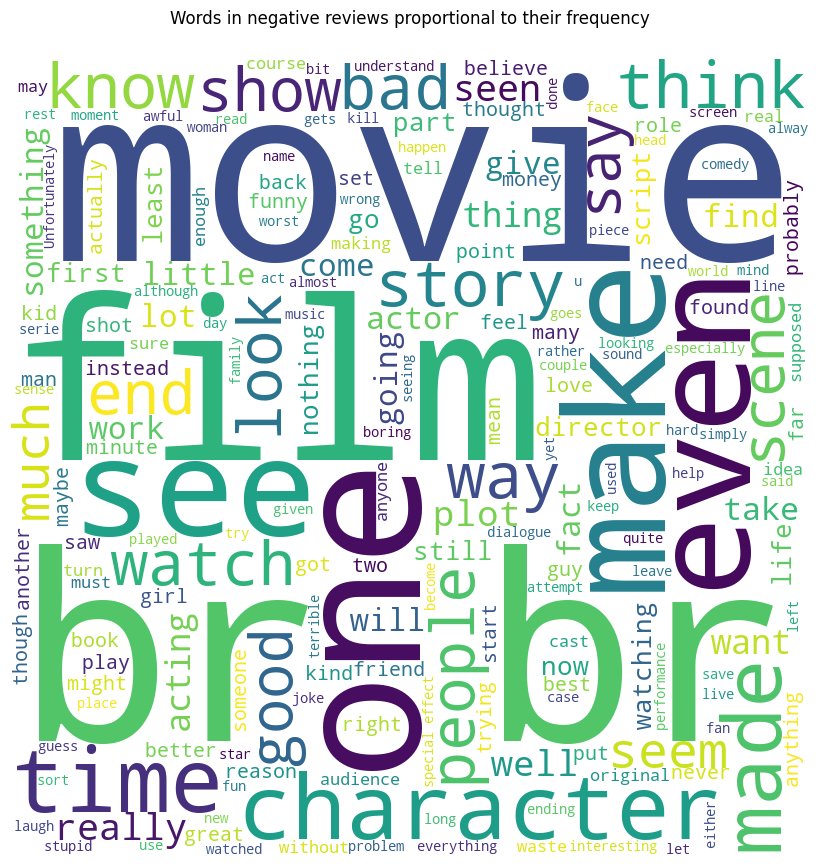

In [34]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
negative_reviews = df[df['tag'] == 'neg']

negative_text = ' '.join(negative_reviews['text'])

negative_wordcloud = WordCloud(stopwords = stopwords, width=800, height=800, background_color='white', min_font_size=10).generate(negative_text)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(negative_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Words in negative reviews proportional to their frequency', pad=25)
plt.show()

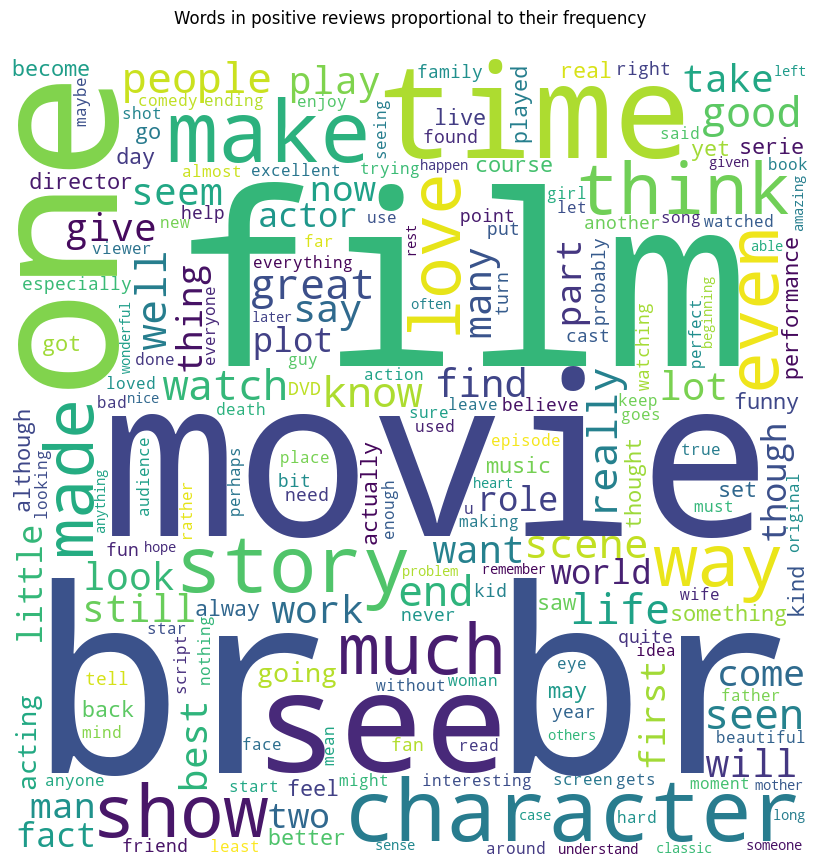

In [35]:
positive_reviews = df[df['tag'] == 'pos']
positive_text = ' '.join(positive_reviews['text'])
positive_wordcloud = WordCloud(stopwords=stopwords, width=800, height=800, background_color='white', min_font_size=10).generate(positive_text)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(positive_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Words in positive reviews proportional to their frequency', pad=25)
plt.show()


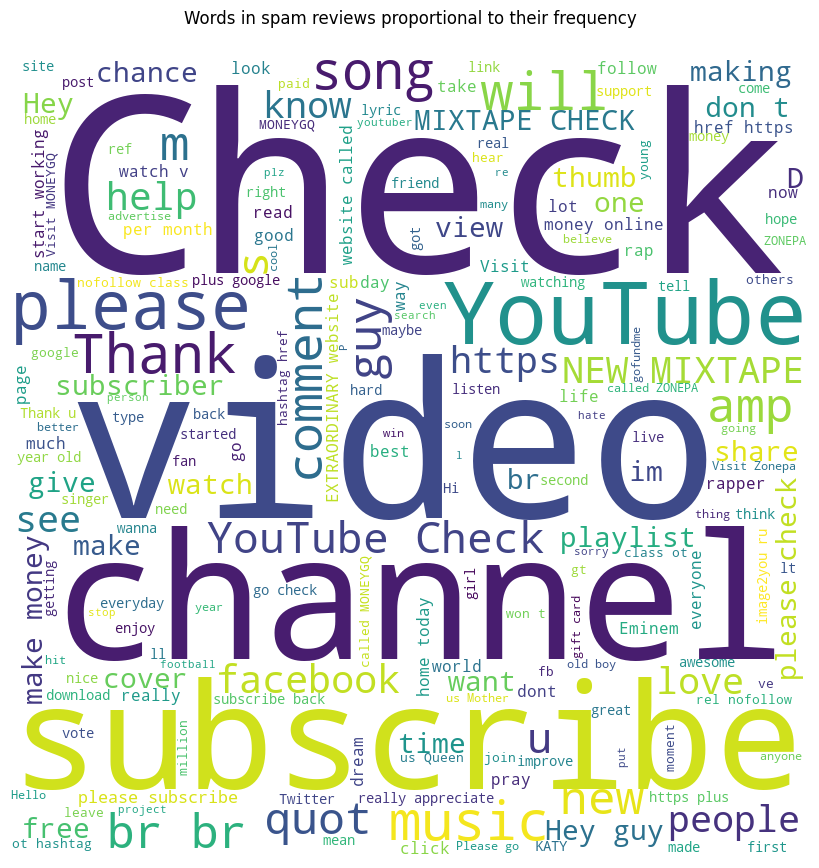

In [36]:
spam = df[df['tag'] == 'spam']
spam_text = ' '.join(spam['text'])
spam_wordcloud = WordCloud(stopwords=stopwords, width=800, height=800, background_color='white', min_font_size=10).generate(spam_text)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Words in spam reviews proportional to their frequency', pad=25)
plt.show()


In conclusion, from the plots above we can already spotted some thing we need to fix in the next phase. For example, we spotted that there are reviews which are only punctuation marks. Another thing we can spot from the most frequent words in reviews per category is `br` which is an HTML tag. Let's continue to next phase.

# 🖌️ Data preparation
The next step after analyzing the data is data cleaning. First thing to do is to remove any contractions. Contraction is when two words are shortened in form and are put together to form one new word ('isn't' , 'aren't' and so on). To fix this we are going to use `contractions` library. The reason we do that contractions can cause issues for the algorithms which are used for training the models.For example, consider the following sentences:
"I don't like pizza."
"I do not like pizza."
These two sentences convey the same meaning, but one uses a contraction while the other does not. If a machine learning algorithm is trained on a dataset that contains both forms of the sentence, it may struggle to recognize that they are equivalent.

In [37]:
import contractions

def expand_contractions(text):
    return contractions.fix(text)

# Apply the function to the text column
df['text'] = df['text'].apply(expand_contractions)
df

,text,tag
0,Bromwell High is a cartoon comedy. It ran at t...,pos
1,Homelessness (or Houselessness as George Carli...,pos
2,Brilliant over-acting by Lesley Ann Warren. Be...,pos
3,This is easily the most underrated film inn th...,pos
4,This is not the typical Mel Brooks film. It wa...,pos
...,...,...
1943,********OMG Facebook is OLD! Check out ------...,spam
1944,Hey Music Fans I really appreciate all of you ...,spam
1945,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,spam
1946,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,spam


Our next step is to convert all the text to lowercase. The reason for that is to standartize and normalize the text(for example: 'dog', 'Dog' and 'DOG' are the same word). 

In [38]:
df['text'] = df['text'].str.lower()

As we mentioned, we noticed in the results from the analysis in the previous phase that there are rows which have only a symbol, no words and HTML tags. To check the exact number of those rows we will check in `text` column for text with less than 5 characters. Moreover, this way we will be able to spot another anomalies in the data.

In [39]:
# negative_reviews_text_lengths = negative_reviews['text'].apply(len)
reviews_less_than_5_characters = df[df['text'].apply(len) < 5]
reviews_less_than_5_characters

,text,tag
559,",",pos
616,?,pos
990,: ),pos
1937,",",pos
3859,.,pos
...,...,...
64496,.,neg
64551,.,neg
64552,.,neg
64564,.,neg


Moreover, as we said one of the things we noticed is HTML tags. Let's get rid of them.

In [43]:
from bs4 import BeautifulSoup
import re

def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text(separator=" ")
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

df['text'] = df['text'].apply(lambda x: remove_html_tags(x))


C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\1293729457.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\1293729457.py:5: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


We got 203 rows. We want to get rid of those rows as they don't bring any value to the model. The following function deletes all special symbols in every review. 

In [44]:
def remove_symbols(review):
    review = re.sub(r'[^\w\s]', '', review)
    return review
df['text'] = df['text'].apply(lambda x: remove_symbols(x))

After running the function from above there the rows that there was only symbol and no text are now empty. In this case we want to drop them.

In [45]:
df = df[df['text'].str.strip().astype(bool)]
df

,text,tag
0,bromwell high is a cartoon comedy it ran at th...,pos
1,homelessness or houselessness as george carlin...,pos
2,brilliant overacting by lesley ann warren best...,pos
3,this is easily the most underrated film inn th...,pos
4,this is not the typical mel brooks film it was...,pos
...,...,...
1943,omg facebook is old check out swagfriends co...,spam
1944,hey music fans i really appreciate all of you ...,spam
1945,check out my new mixtape check out my new mixt...,spam
1946,check out my new mixtape check out my new mixt...,spam


Checking to see if the previous step was successful! 

In [46]:
reviews_less_than_5_characters = df[df['text'].apply(len) < 5]
reviews_less_than_5_characters

,text,tag
2041,huh,pos
2409,yes,pos
3710,why,pos
4173,aha,pos
4365,yup,pos
...,...,...
62822,duh,neg
62954,why,neg
63047,ugh,neg
63196,pg13,neg


From the results above, we can see there are numbers in the dataset. As we do sentiment analysis those numbers don't bring value to the model. That's why we are going to delete them.

In [47]:
def delete_numbers(review):
    review = re.sub(r'\d+', '', review)
    return review
df['text'] = df['text'].apply(lambda x: delete_numbers(x))

C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\633633571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda x: delete_numbers(x))


From the data analysis we did in the previous step, we saw there are reviews which are really long. Those kind of reviews might be considered as outliers because their length is greater compared to the mean values.

In [48]:
# remove all reviews which are longer than 6000 characters
df = df[df['text'].str.len() <= 6000]
df

,text,tag
0,bromwell high is a cartoon comedy it ran at th...,pos
1,homelessness or houselessness as george carlin...,pos
2,brilliant overacting by lesley ann warren best...,pos
3,this is easily the most underrated film inn th...,pos
4,this is not the typical mel brooks film it was...,pos
...,...,...
1943,omg facebook is old check out swagfriends co...,spam
1944,hey music fans i really appreciate all of you ...,spam
1945,check out my new mixtape check out my new mixt...,spam
1946,check out my new mixtape check out my new mixt...,spam


Something important is to check if all reviews are written in English(we are creating a sentiment analysis model using reviews written in English so any reviews written in other language don't bring value to the model). To do that we are going to use `langdetect` library. We are going to create column called `language` where we are going to write the language that has been detected.

In [49]:
from langdetect import detect
#takes 18 minutes
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'
df['language'] = df['text'].apply(detect_language)
df

C:\Users\Admin\AppData\Local\Temp\ipykernel_10184\783158387.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['language'] = df['text'].apply(detect_language)


,text,tag,language
0,bromwell high is a cartoon comedy it ran at th...,pos,en
1,homelessness or houselessness as george carlin...,pos,en
2,brilliant overacting by lesley ann warren best...,pos,en
3,this is easily the most underrated film inn th...,pos,en
4,this is not the typical mel brooks film it was...,pos,en
...,...,...,...
1943,omg facebook is old check out swagfriends co...,spam,en
1944,hey music fans i really appreciate all of you ...,spam,en
1945,check out my new mixtape check out my new mixt...,spam,en
1946,check out my new mixtape check out my new mixt...,spam,en


Let's check what languages are used in the reviews.

In [50]:
df['language'].unique()

array(['en', 'id', 'ro', 'nl', 'af', 'so', 'es', 'sv', 'da', 'pt', 'cy',
       'it', 'tl', 'fr', 'fi', 'sl', 'et', 'tr', 'no', 'sq', 'pl', 'de',
       'vi', 'ca', 'sk', 'hr', 'cs', 'lt', 'unknown', 'sw', 'lv', 'hu'],
      dtype=object)

From the result above we saw there are a lot of languages apart from English. Let's check the exact number of reviews written in any other language than English.

In [51]:
non_english_count = len(df[df['language'] != 'en'])
non_english_count

1922

From above we can see that there aren't many reviews which are not written in English(1914 rows). We are just going to drop them.

In [52]:
df = df[df['language'] == 'en']
df

,text,tag,language
0,bromwell high is a cartoon comedy it ran at th...,pos,en
1,homelessness or houselessness as george carlin...,pos,en
2,brilliant overacting by lesley ann warren best...,pos,en
3,this is easily the most underrated film inn th...,pos,en
4,this is not the typical mel brooks film it was...,pos,en
...,...,...,...
1943,omg facebook is old check out swagfriends co...,spam,en
1944,hey music fans i really appreciate all of you ...,spam,en
1945,check out my new mixtape check out my new mixt...,spam,en
1946,check out my new mixtape check out my new mixt...,spam,en


Let's check the reviews which are less than 5 characters long.

In [53]:
reviews_less_than_5_characters = df[df['text'].apply(len) < 5]
reviews_less_than_5_characters

,text,tag,language
3710,why,pos,en
8455,why,pos,en
25648,why,pos,en
28521,why,pos,en
31107,why,pos,en
31589,why,pos,en
33375,and,neg,en
33468,ugh,neg,en
34740,why,neg,en
34899,why,neg,en


From the results above we can see that those reviews don't bring any value because they are only one word which can be interpreted in several ways. This is why we are going to drop them.

In [54]:
df = df.drop(reviews_less_than_5_characters.index)
df

,text,tag,language
0,bromwell high is a cartoon comedy it ran at th...,pos,en
1,homelessness or houselessness as george carlin...,pos,en
2,brilliant overacting by lesley ann warren best...,pos,en
3,this is easily the most underrated film inn th...,pos,en
4,this is not the typical mel brooks film it was...,pos,en
...,...,...,...
1943,omg facebook is old check out swagfriends co...,spam,en
1944,hey music fans i really appreciate all of you ...,spam,en
1945,check out my new mixtape check out my new mixt...,spam,en
1946,check out my new mixtape check out my new mixt...,spam,en


Our last step from data preparation phase is lemmatization. Lemmatization is a process of reducing a word to its base or root form. It is often performed to normalize words and reduce the dimensionality of text data. There is also another possible approach which is stemming.Although it is slower, we chose lemmatization because stemming removes the last few characters from a word which can make it less accurate. For example:
- 'change', 'changing', 'changes', 'changed' and 'changer' will be converted to 'chang' if we use stemming.
- 'change', 'changing', 'changes', 'changed' and 'changer' will be converted to 'change' if we use lemmatization

See more on https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [55]:
import spacy            # overall accuracy stays the same when using random forest. Only spam category drops a bit of recall and f1-score 
from spacy.lang.en import English

nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def lemmatize_text(df):
    for i, doc in enumerate(nlp.pipe(df['text'].astype('unicode').values, batch_size=100)):
        if doc.is_parsed:
            lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
        else:
            lemmatized_text = None
        df.at[i, 'text'] = lemmatized_text
    return df


# 🛠️ Preprocessing
The step of preprocessing contains several activities to consider before we can start training the algorithm and produce a model that can classify if movie review is positive, negative or spam. 

### 🎯 Target variable
Given that machine learning algorithms work with only numbers and therefore produce only numbers as output, the first thing that needs to be done is ascertaining that the target variable is numeric. A new column named `tag ID` is made, that contains a number for each of the different `tag`, and that becomes the target variable for our model. The thing it needs to predict. In order to fill the new column `tag ID` Here the labels are mapped to integers. Because in our datasets we don't have neutral reviews, the value `0` will represent spam class,`-1` will represent negative reviews and `1` will represent positive reviews.

In [56]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df["tag ID"] = encoder.fit_transform(df["tag"])
df.sample(10)

,text,tag,language,tag ID
3231,a fragment in the life of one of the first fem...,pos,en,1
33457,i am a big fan of italian films from the seven...,neg,en,0
3371,i love horses and admire hand drawn animation ...,pos,en,1
26139,once again i have seen a movie made by people ...,neg,en,0
25401,i adore this film the chemistry between the tw...,pos,en,1
4763,the movie macarthur begins and ends at gen dou...,pos,en,1
256,people forget that there have been several kin...,pos,en,1
34721,i watch this movie all the time i have watched...,pos,en,1
36289,voor een verloren soldaat for a lost soldier ...,neg,en,0
21057,yet it also moves from step to step in such a ...,pos,en,1


### 💡 Feature selection
Perhaps the most important step is 'feature selection', which is the activity of deciding which of the candidate features to use in order to predict the target variable. Given the fact that we want to predict the category of the movie review which is in `tag ID` column, the feature we have to use is the `text` column and `tag ID` will be the target.

In [57]:
features = "text"
target = "tag ID"
X = df[features]
y = df[target]

### 🪓 Splitting into train/test
Before the model can be trained, a little part of the data is to be put aside for testing purposes. The reasoning here is that the model trains with, for example 80% of the data available, and the other 20% is used to ask it to predict the target variable for. Now, because the true target variable of that 20% is known, we can compare the predictions with the ground truth and devise how well the model performs.The vectorizer then turns the corpus of observations in numeric representations for the most prominent words excluding the stop words of the English language. For every observation it will give a `0` for any word that is not present in the observation, or a higher value for a word that is. We are going to take only unigrams due to the fact that if we tak both unigrams and bigrams the training time increases with hours per model.

In [58]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

vectorizer = CountVectorizer(stop_words='english')
# vectorizer = CountVectorizer(stop_words='english', ngram_range = (1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


Taking into consideration the ratio of the categories, we have to change the default value of class_weight. The reason for that is because we have a lot less values from spam class and we have to make sure that the model will be able to predict those too and not be biased. To calculate the class weight values we are going to use [compute_class_weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html).

In [202]:
# when I use this one the accuracy drops severely
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print("Class weights:", dict(zip(np.unique(y_train), class_weights)))
# class_weight = {-1:0.67588348, 0:65.38491547, 1:0.66438076}

Class weights: {0: 0.6759966643352882, 1: 0.6641076124155975, 2: 67.012}


After trying the class weights with the values above, I saw that the result weren't the best. That is why I started changing the values and experimenting. In the end I decided that the values for class weights from below are good enough. 

In [59]:
class_weight = {0: 0.110438213030083432,1: 0.110311996805383198,2: 0.7792497901645334}

# 🧬 Modelling
One of the most popular algorithms used for sentiment analysis is [logistic regression CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html).

Logistic regression is a binary classification algorithm commonly used in sentiment analysis for movie reviews.The output of the logistic regression model is a probability score between 0 and 1 that represents the likelihood of the given review belonging to each class. The class with the highest probability is selected as the predicted sentiment label for the review. In order to prevent biases we will use the hyperparameter `class_weight` to adjust the weight of each class. This way we can improve the overall accuracy of the model and also the accuracy on classifying the categories with less values(in our case this is spam).`multinomal` is used because we have three type of reviews. `cv` is the crossvalidation which aims for better results.


In [60]:
lr = LogisticRegressionCV(multi_class='multinomial', class_weight=class_weight, cv=5,scoring='accuracy',random_state=1,n_jobs=-1,verbose=3,max_iter=750)
lr.fit(X_train_vec, y_train)

y_pred = lr.predict(X_test_vec)
accuracy = np.mean(y_pred == y_test)    
print("Accuracy:",accuracy)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 31.2min remaining: 46.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 32.1min finished


Accuracy: 0.8803024273776363


# 🔬 Evaluation

In order to have more clarity and more detailed sight on the results a classification report can be printed. This will show details on how the model perform with the training set and the test set as:
- precision - is the ratio of true positive predictions to the total number of positive predictions.
- recall - is the ratio of true positive predictions to the total number of actual positive cases.
- f1-score - is a harmonic mean of precision and recall, and it is a way to combine these two metrics into a single measure.
- support - evaluates the number of samples that belong to each class.

In [140]:
from sklearn.metrics import classification_report

y_train_pred = lr.predict(X_train_vec)
print("Train set:")
print(classification_report(y_train, y_train_pred))

y_pred = lr.predict(X_test_vec)
print("Test set:")
print(classification_report(y_test, y_pred))


Train set:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     74251
           1       0.96      0.96      0.96     75761
           2       0.99      1.00      0.99       767

    accuracy                           0.96    150779
   macro avg       0.97      0.97      0.97    150779
weighted avg       0.96      0.96      0.96    150779

Test set:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     18667
           1       0.88      0.88      0.88     18853
           2       0.92      0.81      0.86       175

    accuracy                           0.88     37695
   macro avg       0.89      0.86      0.87     37695
weighted avg       0.88      0.88      0.88     37695



For further information confusion matrix is displayed. There are four possible categorical predictions:
- true positive(TP) - in our case the model has successfully predicted the reviews as positive
- false positive(FP) - the model has failed to predict the reviews as negative
- true negative(TN) - the model has successfully predicted the reviews as negative
- false negative(FN) - the model has failed to predict the reviews as positive

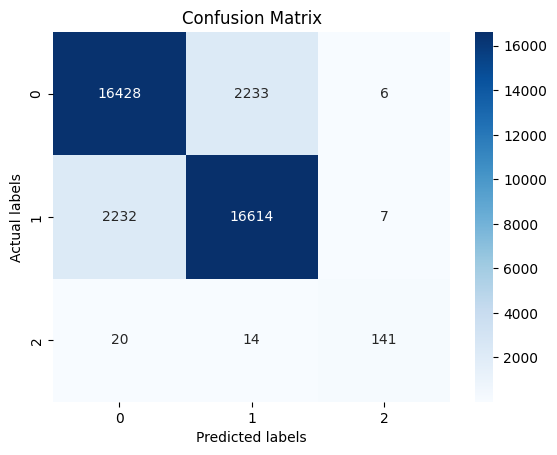

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = lr.predict(X_test_vec)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion Matrix')

plt.show()


Let's take a look at some examples and how the model performs. A sample of 10 reviews will be displayed.

In [68]:
columns = {'neg': lr.classes_[0], 'pos': lr.classes_[1], 'spam': lr.classes_[2]}
pred = lr.predict_proba(X_test_vec)
predictions = pd.DataFrame(pred, columns=columns.keys())
predictions["truth"] = [ 'neg' if i==0 else 'pos' if i==1 else 'spam' for i in y_test ]
predictions["text"] = X_test.values

for col in columns.keys():
    predictions[col] = predictions[col].apply(lambda x: '{:.2%}'.format(x))

#makes the dataframe look bigger
pd.set_option('display.max_colwidth', 1000)

predictions.sample(10)


,neg,pos,spam,truth,text
28514,0.04%,99.96%,0.00%,pos,this series was just like what you would expect from mrspielberg it is truly one of those frighting funny childish shows that you will not forget just like outer limits another great show this little series does what not a lot can it was great and deserved to run longer it was a great show that even kids could watch though some of the shows were a little scary when they wanted to be but all of them always had a moral at the end like the twilight zone that made you realize what situation you did not want to end up in or ones that you did i remember watching some of these on scifi when i was and even now i still enjoy seeing them when i can truly a fun imaginative show i loved it and still do
9837,94.06%,5.94%,0.00%,neg,what can i say i think i have to write spoiler alert and then reveal they used the fword a lot in this movie like in every two sentences i did not like this movie at all too much hints on sexual perversions sidesteps and cheating and that swearing was totally out the window i gave this movie and two of those points are for mira sorvinos sexy movements on the dance floor
4945,0.00%,100.00%,0.00%,pos,tell you what that was excellent dylan moran is simply the funniest actor on screen and on stage and with micheal caine as your partner are not to bad either both are great to watch in a really funny film true not all the gags come off but its worth sticking around for the ones that do but come on its got micheal caine in a dress in it the whole admission fees worth that and every time dylan morans on screen its more like bernard blacks movie the story is two actorsmoran and caine who decide to steal money from a group of gangsters by acting out different personas to fool them all but getting away with it is a different matter basically the actors is a great british comedy that was somehow missed by many seriously if your a moran fanor want to see micheal caine in a dress definitely see this
6925,93.48%,6.52%,0.00%,neg,there is a growing trend in the media to vilify and ridicule men one sees it in television adverts and program plots cheaters is a prime example they could find plenty of female cheaters yet the vast majority shown are men why the prime threat to any governments power resides in the male population they are less likely to abide by authority and are more of a physical combat threat a way to reduce the threat is to emasculate men in society via the media other examples of psychological propaganda are crime dramas full of self righteous cops including bigjawed aggressive women accusing everyone they question trampling their rights and making those men feel like scum in australia many top male sports stars have been arrested recently for dubious assaults and drinking charges another example of the government controlling the male populous by arresting their heroes and asserting dominance cheaters aside from the political machinations is an invasion of privacy and a violation of rights f...
28348,1.19%,98.81%,0.00%,pos,an excellent interpretation of jim thompsons novel this neonoir thriller has all the requisite elementsderanged exboxer turned drifter alcoholic widow with sinister desires excop turned smalltime crook and a kidnap plot destined for doom yet the film never crosses into cliche country but remains fresh and intriguing the performances are all superb particularly bruce derns role as the wicked sleazeball uncle bud there is a tense uncertainty to the films movement which intentional or not adds to the grim proceedings highly recommended
7202,0.32%,99.68%,0.00%,pos,it is highly stylized but this movie shows that real people appear on these shows and what seems like good fun and a chance to appear on television can have serious consequences yes is mostly comedy but there are some sad moments
22117,0.00%,100.00%,0.00%,pos,fat man and little boy were the code names of the two atomic bombs that were dropped in reverse order on nagasaki and hiroshina h

Let's try the model with few sentences we are going to write.

In [69]:
message = "I hate the movie"
message_vectorized = vectorizer.transform([message]).toarray()
inference = lr.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = lr.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)


     neg    pos  spam
0  49.27  50.61  0.12
Predicted sentiment: pos


In [70]:
message = "This movie was a mixed bag. While some of the performances were strong and the production value was high, the plot was convoluted and difficult to follow. The ending left me feeling unsatisfied and confused. Overall, I can't say whether I liked it or not."
message_vectorized = vectorizer.transform([message]).toarray()
inference = lr.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = lr.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)


     neg    pos  spam
0  18.13  81.87   0.0
Predicted sentiment: pos


In [71]:
message = "HEY! CHECK OUT MY NEW MIXTAPE RIGHT NOW"
message_vectorized = vectorizer.transform([message]).toarray()
inference = lr.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = lr.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)


    neg   pos   spam
0  0.62  0.72  98.65
Predicted sentiment: spam


For further examination of the model, we can extract the keywords from sentence using [Rake](https://pypi.org/project/rake-nltk/). This algorithm will extract the keywords from the text and then we are going to save them in a list. After that, we are going to create dataframe so we can check the result in the end. Finally, we are looping through every keyword in the list and predicting its sentiment.

In [72]:
import nltk
from nltk.tokenize import word_tokenize
from rake_nltk import Rake

# nltk.download('punkt')        # if there are problems with downloading/installing use this
# nltk.download('stopwords')    # if there are problems with downloading/installing use this

text = "The movie was okay. It could have been better for sure but for 2023 it works."   # Sample text
tokens = word_tokenize(text)
# stop_words = set(stopwords.words('english'))
tokens = [token for token in tokens if token.lower() not in stop_words]

r = Rake()
r.extract_keywords_from_text(text)
keywords = r.get_ranked_phrases()

resultDf = pd.DataFrame(columns=['Keyword', 'Predicted Sentiment', 'Negative Probability', 'Positive Probability', 'Spam Probability'])

for keyword in keywords:
    keyword_vectorized = vectorizer.transform([keyword]).toarray()
    inference = lr.predict_proba(keyword_vectorized)[0].round(3)
    predicted_label = lr.predict(keyword_vectorized)[0]
    if predicted_label == 0:
        predicted_sentiment = 'neg'
    elif predicted_label == 1:
        predicted_sentiment = 'pos'
    else:
        predicted_sentiment = 'spam'
    row = {'Keyword': keyword, 'Predicted Sentiment': predicted_sentiment, 'Negative Probability': inference[0], 'Positive Probability': inference[1], 'Spam Probability': inference[2]}
    resultDf = pd.concat([resultDf, pd.DataFrame(row, index=[0])], ignore_index=True)

resultDf


,Keyword,Predicted Sentiment,Negative Probability,Positive Probability,Spam Probability
0,works,pos,0.344,0.649,0.007
1,sure,pos,0.479,0.518,0.004
2,okay,neg,0.572,0.413,0.015
3,movie,neg,0.542,0.458,0.001
4,could,neg,0.506,0.477,0.017
5,better,neg,0.590,0.405,0.005
6,2023,neg,0.506,0.477,0.017


Let's test our model with longer review. `min_length=1` and `max_length=1` mean that only single words will be extracted as keywords insted of several together. Below, we are going to try without putting those boundaries. Again for each keyword will be predicted the sentiment in percentages which are rounded up to their 3rd symbol after the decimal point.

In [73]:
text = """After months of anticipation, I finally watched the highly acclaimed movie that everyone has been raving about. The film was a sweeping epic, with a sprawling cast of characters and a complex, multi-layered storyline. The cinematography was stunning, with breathtaking landscapes and intricate set designs that transported me to another world.

At the heart of the film was a poignant love story between the two main characters, played by two incredibly talented actors who had an undeniable chemistry on screen. Their performances were riveting and nuanced, conveying a range of emotions from joy and love to heartbreak and despair.

The supporting cast was equally impressive, with standout performances from several veteran actors who brought depth and nuance to their roles. The dialogue was smart and snappy, with clever quips and one-liners that kept me engaged and entertained throughout the film.

While the film was undeniably a triumph of filmmaking, there were a few missteps along the way. Some of the plot points felt rushed or underdeveloped, leaving me with more questions than answers. Additionally, the film's pacing could have been tighter, with some scenes feeling overly long or dragging on without purpose.

Despite these minor flaws, the film was a tour de force of cinema, and one that will surely be remembered for years to come. I left the theater feeling moved and inspired, eager to revisit the film and uncover new layers and meanings in its intricate story."""  # Sample text

tokens = word_tokenize(text)
# stop_words = set(stopwords.words('english'))
tokens = [token for token in tokens if token.lower() not in stop_words]

r = Rake(min_length=1, max_length=1)
r.extract_keywords_from_text(text)
keywords = r.get_ranked_phrases()

resultDf = pd.DataFrame(columns=['Keyword', 'Predicted Sentiment', 'Negative Probability', 'Positive Probability', 'Spam Probability'])

for keyword in keywords:
    keyword_vectorized = vectorizer.transform([keyword]).toarray()
    inference = lr.predict_proba(keyword_vectorized)[0].round(3)
    predicted_label = lr.predict(keyword_vectorized)[0]
    if predicted_label == 0:
        predicted_sentiment = 'neg'
    elif predicted_label == 1:
        predicted_sentiment = 'pos'
    else:
        predicted_sentiment = 'spam'
    row = {'Keyword': keyword, 'Predicted Sentiment': predicted_sentiment, 'Negative Probability': inference[0], 'Positive Probability': inference[1], 'Spam Probability': inference[2]}
    resultDf = pd.concat([resultDf, pd.DataFrame(row, index=[0])], ignore_index=True)

resultDf


,Keyword,Predicted Sentiment,Negative Probability,Positive Probability,Spam Probability
0,years,pos,0.492,0.504,0.005
1,way,pos,0.477,0.512,0.011
2,underdeveloped,neg,0.634,0.351,0.015
3,undeniably,pos,0.475,0.509,0.016
4,triumph,pos,0.284,0.701,0.014
...,...,...,...,...,...
57,cinema,neg,0.554,0.436,0.011
58,characters,neg,0.513,0.485,0.002
59,anticipation,neg,0.587,0.398,0.015
60,answers,pos,0.393,0.593,0.014


Let's take a look into the number of negative keywords.

In [74]:
neg_number = len(resultDf[resultDf['Predicted Sentiment'] == 'neg'])
neg_number

30

Let's take a look into the number of positive keywords.

In [75]:
pos_number = len(resultDf[resultDf['Predicted Sentiment'] == 'pos'])
pos_number

32

In [76]:
spam_number = len(resultDf[resultDf['Predicted Sentiment'] == 'spam'])
spam_number

0

Let's also check the predicted sentiment of the long review. Everyone can read the review and decide if the model is accurate.

In [77]:
message = text
message_vectorized = vectorizer.transform([message]).toarray()
inference = lr.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = lr.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)

   neg    pos  spam
0  0.0  100.0   0.0
Predicted sentiment: pos


Now we won't use any boundaries for the keywords extraction.

In [78]:
r = Rake()
r.extract_keywords_from_text(text)
keywords = r.get_ranked_phrases()

resultDf = pd.DataFrame(columns=['Keyword', 'Predicted Sentiment', 'Negative Probability', 'Positive Probability', 'Spam Probability'])

for keyword in keywords:
    keyword_vectorized = vectorizer.transform([keyword]).toarray()
    inference = lr.predict_proba(keyword_vectorized)[0].round(3)
    predicted_label = lr.predict(keyword_vectorized)[0]
    if predicted_label == 0:
        predicted_sentiment = 'neg'
    elif predicted_label == 1:
        predicted_sentiment = 'pos'
    else:
        predicted_sentiment = 'spam'
    row = {'Keyword': keyword, 'Predicted Sentiment': predicted_sentiment, 'Negative Probability': inference[0], 'Positive Probability': inference[1], 'Spam Probability': inference[2]}
    resultDf = pd.concat([resultDf, pd.DataFrame(row, index=[0])], ignore_index=True)

resultDf

,Keyword,Predicted Sentiment,Negative Probability,Positive Probability,Spam Probability
0,plot points felt rushed,neg,0.509,0.490,0.001
1,scenes feeling overly long,neg,0.623,0.376,0.001
2,two incredibly talented actors,neg,0.626,0.357,0.017
3,theater feeling moved,neg,0.518,0.478,0.004
4,several veteran actors,pos,0.476,0.523,0.001
...,...,...,...,...,...
86,cinematography,neg,0.561,0.428,0.011
87,cinema,neg,0.554,0.436,0.011
88,anticipation,neg,0.587,0.398,0.015
89,answers,pos,0.393,0.593,0.014


Again checking the number of negative keywords.

In [79]:
neg_number = len(resultDf[resultDf['Predicted Sentiment'] == 'neg'])
neg_number

40

Again checking the number of positive keywords.

In [80]:
pos_number = len(resultDf[resultDf['Predicted Sentiment'] == 'pos'])
pos_number

51

In [81]:
spam_number = len(resultDf[resultDf['Predicted Sentiment'] == 'spam'])
spam_number

0

# 🧬 Modelling
The second algorithm we are going to use is [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree. The values for the decision tree were chosen after performing several experiments with different values. 

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rfc = RandomForestClassifier(class_weight=class_weight, n_estimators= 70,max_depth=125, random_state=42, n_jobs=-1)
rfc.fit(X_train_vec, y_train)

# Evaluate the performance on the testing set
y_pred = rfc.predict(X_train_vec)
print("Train set:")
print(classification_report(y_train, y_pred))
# print(classification_report(y_test, y_pred)
y_pred = rfc.predict(X_test_vec)
print("Test set:")
print(classification_report(y_test, y_pred))


Train set:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     74251
           1       0.85      0.97      0.91     75761
           2       1.00      0.78      0.88       767

    accuracy                           0.90    150779
   macro avg       0.94      0.86      0.89    150779
weighted avg       0.91      0.90      0.90    150779

Test set:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     18667
           1       0.81      0.94      0.87     18853
           2       1.00      0.63      0.78       175

    accuracy                           0.86     37695
   macro avg       0.91      0.78      0.83     37695
weighted avg       0.87      0.86      0.85     37695



# 🔬 Evaluation
Confusion matrix will be printed to show more in-depth information.

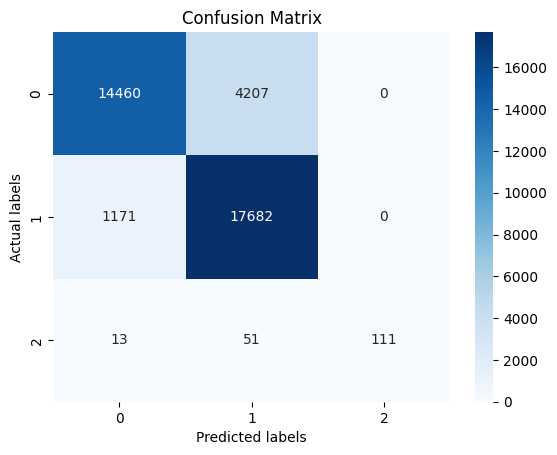

In [83]:
cm = confusion_matrix(y_test, y_pred)
seaborn.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion Matrix')

plt.show()

Let's take a look at some examples and how the model performs. A sample of 10 reviews will be displayed.

In [84]:
pred = rfc.predict_proba(X_test_vec)
predictions = pd.DataFrame(pred, columns=columns.keys())
predictions["truth"] = [ 'neg' if i==0 else 'pos' if i==1 else 'spam' for i in y_test ]
predictions["text"] = X_test.values

for col in columns.keys():
    predictions[col] = predictions[col].apply(lambda x: '{:.2%}'.format(x))

#makes the dataframe look bigger
pd.set_option('display.max_colwidth', 1000)

predictions.sample(10)


,neg,pos,spam,truth,text
5842,41.66%,55.55%,2.79%,pos,still all the while sidney stays concealed in her home only visiting dad for the first halfhour of the film while also having horrifying visions of her mother which takes us back a bit to sidney s fear of becoming what her mother was or at least what her mother was secretly
6899,34.88%,64.66%,0.47%,pos,at the time that this movie was made most housewives knew exactly who barbara stanwick was parodyingtoday only some women over probably remember gladys taberwhose column butternut wisdom ran in family circle magazine from before world war ii until the sshe lived on stillmeadow farm in conecticutand her columns were collected into a number of booksstillmeadow seasons stillmeadow daybook etc the lines that barbara stanwick recites as she types them for her column are quite typical of the ones that began a typical gladys taber columnbesides cooking and country livingshe got rather nostalgic and philosophical at timesshe talked a lot about her favorite dogs mostly cocker spanielsyou might say that martha stewart is the gladys tabor of today christmas is connecticut may not be any cinematic masterpiecebut it is pleasantlighthearted entertainmentsoothing to the stressed out mindand that is good enough
34283,91.56%,8.34%,0.10%,neg,this must rate with the worst films i have ever seen it just was not funny my wife fell asleep i suppose if you are the sort of person who goes all gooey eyed at the sight of a dog then it may do something for you if you expect a comedy film to have some humour in it then you will be disappointed unless you find an english radio announcer saying the f word a lot hilarious the strippers in the club kept their underwear on so there was not even a bit of nudity to relieve the boredom what did happen in the strip club made no sense at all there was a great deal of mumbling by the lead character with whom i developed no sympathy at all mena suvari was hardly in the film presumably just there to make people think it was a serious attempt at producing a film the bad guys were unconvincing and carried as much menace as a dead sheep
4868,90.05%,9.91%,0.04%,neg,this film is truly pathetic in every conceivable department awful awful awful it is only around eighty minutes long but believe me you will feel like you are watching an andy warhol film then again twenty hours in the life of the empire state building would surely be far more interesting where to start the putrid script the disgusting cinematography the so bad its bad acting the spectacularly dismal effects dreadful music or just the wafer thin plot that thouroughly resembles a sieve this film is an incoherent shambles a particularly noteworthy scene takes place outside a cafe when dominic pinon decides to shoot a cat cue the waitress watching through the cafe window who comments with an average english accent god damn to right that woman god damn this horrendous monstrosity everyone involved should be thouroughly ashamed of themselves let us hope that the director never finds the funding to work again
25985,16.17%,83.36%,0.48%,pos,this lightheated for cassaveteslove story is pleasantly conveyed by two wonderful performances by gena rowlands and seymour cassell rowlands was never more beautiful as a repressed damaged mids woman who meets her match in seymour cassell is a powderkeg of energy and romantic notions on his terms there is a great supporting performance by val avery as zelmo swift and an unusual as always timothy carey that is worth the price of admission made between husbands and a woman under the influence this is cass most accessible film that should touch the heart of anyone especially the cassavetes haters who claim his films are too long and ponderously heavy at times made my top ten that year and not seen by enough people an out of
23109,46.40%,53.52%,0.08%,pos,after the success of muppet babies warner brothers chalked up tiny toons but instead of making bugs bunny daffy duck and all the rest

Let's try the model with few sentences we are going to write.

In [85]:
message = "I hate the movie"
message_vectorized = vectorizer.transform([message]).toarray()
inference = rfc.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = rfc.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)

     neg    pos  spam
0  47.91  48.34  3.75
Predicted sentiment: pos


Sometimes the RandomForestClassifier model determines the above sentence as positive while is negative. To check why and how it classifies each of the words in the sentence, we will print them.

In [86]:
tokens = word_tokenize(message)
for token in tokens:
    token_vectorized = vectorizer.transform([token]).toarray()
    inference = rfc.predict_proba(token_vectorized)[0]
    predicted_label = rfc.predict(token_vectorized)[0]
    predicted_sentiment = 'neg' if predicted_label == 0 else 'pos' if predicted_label == 1 else 'spam'
    print("Token: ", token)
    print("Predicted sentiment: ", predicted_sentiment)
    print("Inference: ", inference)


Token:  I
Predicted sentiment:  pos
Inference:  [0.45926966 0.48987225 0.05085809]
Token:  hate
Predicted sentiment:  pos
Inference:  [0.45926966 0.48987225 0.05085809]
Token:  the
Predicted sentiment:  pos
Inference:  [0.45926966 0.48987225 0.05085809]
Token:  movie
Predicted sentiment:  pos
Inference:  [0.4791263  0.48337057 0.03750312]


Let's try how this model performs with longer negative reviews. 

In [87]:
message = """After hearing all the hype, I was really excited to see this movie. But from the very beginning, I could tell that something was off. The pacing was slow and plodding, and the characters felt wooden and one-dimensional.

As the movie went on, I found myself getting more and more frustrated with the plot. It was convoluted and confusing, with too many twists and turns that didn't seem to add up to anything. And just when I thought things couldn't get any worse, the ending came out of nowhere and left me feeling completely unsatisfied.

To make matters worse, the acting was subpar at best. The lead actor was completely miscast, and his performance was flat and unconvincing. And don't even get me started on the supporting cast, who were equally unremarkable.

Overall, I was really disappointed with this movie. It had all the makings of a great film, but instead it fell completely flat. I wouldn't recommend it to anyone, and I certainly won't be watching it again anytime soon because I hate it."""
message_vectorized = vectorizer.transform([message]).toarray()
inference = rfc.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = rfc.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)

     neg    pos  spam
0  53.06  46.85  0.09
Predicted sentiment: neg


Let's try with another sentence which has mixed emotions(both positive and negative).

In [88]:
message = "This movie was a mixed bag. While some of the performances were strong and the production value was high, the plot was convoluted and difficult to follow. The ending left me feeling unsatisfied and confused. Overall, I can't say whether I liked it or not."
message_vectorized = vectorizer.transform([message]).toarray()
inference = rfc.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = rfc.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)


    neg    pos  spam
0  39.2  58.61   2.2
Predicted sentiment: pos


As we can see below the model has no problems classifying spam reviews but it is not that 'sure' as the previous model.  

In [89]:
message = "HEY! CHECK OUT MY NEW MIXTAPE RIGHT NOW"
message_vectorized = vectorizer.transform([message]).toarray()
inference = rfc.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = rfc.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)


     neg    pos   spam
0  28.05  28.67  43.29
Predicted sentiment: spam


In [90]:
text = "The movie was okay. It could have been better for sure but for 2023 it works."   # Sample text
tokens = word_tokenize(text)
# stop_words = set(stopwords.words('english'))
tokens = [token for token in tokens if token.lower() not in stop_words]

r = Rake()
r.extract_keywords_from_text(text)
keywords = r.get_ranked_phrases()

resultDf = pd.DataFrame(columns=['Keyword', 'Predicted Sentiment', 'Negative Probability', 'Positive Probability', 'Spam Probability'])

for keyword in keywords:
    keyword_vectorized = vectorizer.transform([keyword]).toarray()
    inference = rfc.predict_proba(keyword_vectorized)[0].round(3)
    predicted_label = rfc.predict(keyword_vectorized)[0]
    if predicted_label == 0:
        predicted_sentiment = 'neg'
    elif predicted_label == 1:
        predicted_sentiment = 'pos'
    else:
        predicted_sentiment = 'spam'
    row = {'Keyword': keyword, 'Predicted Sentiment': predicted_sentiment, 'Negative Probability': inference[0], 'Positive Probability': inference[1], 'Spam Probability': inference[2]}
    resultDf = pd.concat([resultDf, pd.DataFrame(row, index=[0])], ignore_index=True)

resultDf


,Keyword,Predicted Sentiment,Negative Probability,Positive Probability,Spam Probability
0,works,pos,0.431,0.524,0.045
1,sure,pos,0.459,0.490,0.051
2,okay,neg,0.478,0.474,0.048
3,movie,pos,0.479,0.483,0.038
4,could,pos,0.459,0.490,0.051
5,better,neg,0.490,0.469,0.041
6,2023,pos,0.459,0.490,0.051


In [91]:
text = """After months of anticipation, I finally watched the highly acclaimed movie that everyone has been raving about. The film was a sweeping epic, with a sprawling cast of characters and a complex, multi-layered storyline. The cinematography was stunning, with breathtaking landscapes and intricate set designs that transported me to another world.

At the heart of the film was a poignant love story between the two main characters, played by two incredibly talented actors who had an undeniable chemistry on screen. Their performances were riveting and nuanced, conveying a range of emotions from joy and love to heartbreak and despair.

The supporting cast was equally impressive, with standout performances from several veteran actors who brought depth and nuance to their roles. The dialogue was smart and snappy, with clever quips and one-liners that kept me engaged and entertained throughout the film.

While the film was undeniably a triumph of filmmaking, there were a few missteps along the way. Some of the plot points felt rushed or underdeveloped, leaving me with more questions than answers. Additionally, the film's pacing could have been tighter, with some scenes feeling overly long or dragging on without purpose.

Despite these minor flaws, the film was a tour de force of cinema, and one that will surely be remembered for years to come. I left the theater feeling moved and inspired, eager to revisit the film and uncover new layers and meanings in its intricate story."""  # Sample text

tokens = word_tokenize(text)
# stop_words = set(stopwords.words('english'))
tokens = [token for token in tokens if token.lower() not in stop_words]

r = Rake(min_length=1, max_length=1)
r.extract_keywords_from_text(text)
keywords = r.get_ranked_phrases()

resultDf = pd.DataFrame(columns=['Keyword', 'Predicted Sentiment', 'Negative Probability', 'Positive Probability', 'Spam Probability'])

for keyword in keywords:
    keyword_vectorized = vectorizer.transform([keyword]).toarray()
    inference = rfc.predict_proba(keyword_vectorized)[0].round(3)
    predicted_label = rfc.predict(keyword_vectorized)[0]
    if predicted_label == 0:
        predicted_sentiment = 'neg'
    elif predicted_label == 1:
        predicted_sentiment = 'pos'
    else:
        predicted_sentiment = 'spam'
    row = {'Keyword': keyword, 'Predicted Sentiment': predicted_sentiment, 'Negative Probability': inference[0], 'Positive Probability': inference[1], 'Spam Probability': inference[2]}
    resultDf = pd.concat([resultDf, pd.DataFrame(row, index=[0])], ignore_index=True)

resultDf.sample(10)

,Keyword,Predicted Sentiment,Negative Probability,Positive Probability,Spam Probability
46,engaged,pos,0.459,0.490,0.051
20,performances,pos,0.416,0.542,0.041
51,despite,pos,0.449,0.503,0.047
35,heartbreak,pos,0.459,0.490,0.051
24,nuance,pos,0.459,0.490,0.051
27,meanings,pos,0.459,0.490,0.051
19,played,pos,0.458,0.492,0.050
60,answers,pos,0.459,0.490,0.051
13,riveting,pos,0.440,0.512,0.048
31,leaving,pos,0.459,0.490,0.051


In [92]:
neg_number = len(resultDf[resultDf['Predicted Sentiment'] == 'neg'])
neg_number

1

In [93]:
pos_number = len(resultDf[resultDf['Predicted Sentiment'] == 'pos'])
pos_number

61

In [94]:
message = text
message_vectorized = vectorizer.transform([message]).toarray()
inference = rfc.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = rfc.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)

     neg    pos  spam
0  22.52  77.26  0.23
Predicted sentiment: pos


# 🧬 Modelling
The third model we are going to use is [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). Multinomial Naive Bayes model learns from occurrences between features such as word counts and discrete classes. The input vector must contain positive values, such as counts or TF-IDF values. It is called Naive Bayes because the calculations of the probabilities for each class are simplified to make their calculations tractable. We can see from below that this is our worst performing model because of its simplicity.

In [95]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(class_prior=[class_weight[i] for i in sorted(class_weight.keys())])
mnb.fit(X_train_vec, y_train)

accuracy = mnb.score(X_test_vec, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8171906088340629


# 🔬 Evaluation

In [96]:
y_pred = mnb.predict(X_train_vec)
print("Train set:")
print(classification_report(y_train, y_pred))
y_pred = mnb.predict(X_test_vec)
print("Test set:")
print(classification_report(y_test, y_pred))

Train set:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85     74251
           1       0.86      0.83      0.84     75761
           2       0.38      0.76      0.50       767

    accuracy                           0.84    150779
   macro avg       0.69      0.82      0.73    150779
weighted avg       0.85      0.84      0.84    150779

Test set:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82     18667
           1       0.83      0.80      0.82     18853
           2       0.36      0.64      0.46       175

    accuracy                           0.82     37695
   macro avg       0.67      0.76      0.70     37695
weighted avg       0.82      0.82      0.82     37695



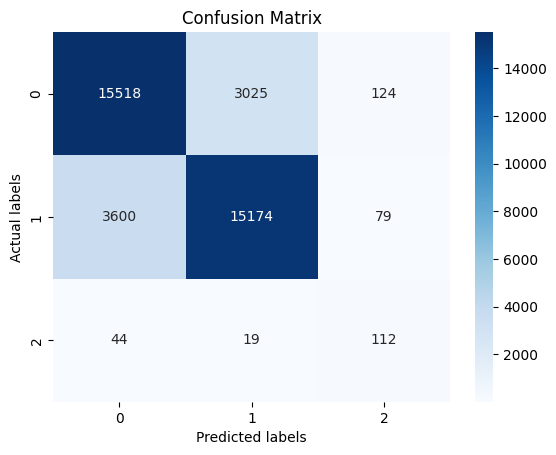

In [97]:
cm = confusion_matrix(y_test, y_pred)
seaborn.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion Matrix')

plt.show()

In [98]:
pred = mnb.predict_proba(X_test_vec)
predictions = pd.DataFrame(pred, columns=columns.keys())
predictions["truth"] = [ 'neg' if i==0 else 'pos' if i==1 else 'spam' for i in y_test ]
predictions["text"] = X_test.values

for col in columns.keys():
    predictions[col] = predictions[col].apply(lambda x: '{:.2%}'.format(x))

#makes the dataframe look bigger
pd.set_option('display.max_colwidth', 1000)

predictions.sample(10)

,neg,pos,spam,truth,text
12303,31.78%,68.22%,0.00%,pos,this show was incredible but too esoteric for most people if you had never truly seen a european variety show in the s or s or at least a mexican one the entire show would probably be lost on you if you had this show was a dead on skewering satire of the phony spectacle and shallowness that these shows dive into at their worst helmed by a chainsmoking suave wannabe with a pencil moustache and his ultraglamorous and immasculating harridan of an exwife viva variety is a variety show that tries to get off the ground every episode but always descends into infighting and acts gone very wrong the hosts are joined by johnny bluejeans a dim witted sidekick who seems to have been named because blue jeans are a very popular product in his country and that means the kids will like him which of course they do not the result was a hilarious spoof of variety shows in general imagine the arguing that probably happened backstage during the last days of the sonny cher show now imagine it is happen...
34730,79.97%,20.03%,0.00%,neg,some of the best scenes are apes running into battle looking like they have ape posture but when they start flying through the air the effect is lost
33607,99.96%,0.04%,0.00%,neg,her cardboard lover is norma shearers last movie she quit the movies and i think joined the board of directors at mgm that was a good move on her part her cardboard lover was talky and boring in parts it was obvious there were only a handful of actors with speaking parts so they had a lot of dialogue to speak to keep this turkey afloat the story was a good idea about a wealthy woman norma shearer hiring a man robert taylor to make her playboy fiancee george sandersjealous i am surprised that the director george cukor did not cut many of the talky scenes between ms shearer and mr taylor mr cukor served ms shearer well in the women but not in this movie the best performance in the movie was given by robert taylor during mr taylors career he was given his best comedy roles in this movie and when ladies meet in in he gave his best comedy performance in her cardboard lover and up to then his best dramatic performance in johnny eager he had a busy year i think of all the actors at mg...
30178,100.00%,0.00%,0.00%,pos,ed coincidentally an editor is hired to cut horror films down to be favorable in europe where standards are much more rigorous but he finds the films very minddestroying and starts going a little bit mad okay a little bit might be an understatement let me just say this first of all best opening scene ever a man in an office who blows up his head with a grenade his boss then says with a straight face you are fired the entire film does not keep up this level of intensity but it certainly tries take the shotgun scenes the decapitation the clips from lost limbs which my friend jason wishes were a real film the writer of this film thought up the idea of a woman who gets raped by a beaver and then immediately after gets shot in the face with a bazooka that is something you will not find in any other movie at least i am pretty doubtful you will this films biggest flaw is the quality the picture is not as crisp as a film should be and the sound could be touched up though it is not bad i...
14623,100.00%,0.00%,0.00%,neg,if i could i would give zero stars for this one but unfortunately i have to give one there is no single scene i could laugh about but the game did not make me laugh either so if you are some ill retarded folk go to your local cinema watch this movie and give it stars like some people here already did but for me in a movie where children are shot dead to achieve humor good taste goes over the edge this was the third time i wasted my time to see a boll movie and it was definitely my last i am ashamed of being from the same country as uwe boll please please keep him from making more movies
6263,0.00%,100.00%,0.00%,pos,this film was quite a surprise i was not expecting much to be

In [99]:
message = "I hate the movie"
message_vectorized = vectorizer.transform([message]).toarray()
inference = mnb.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = mnb.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)

     neg    pos  spam
0  64.77  35.15  0.08
Predicted sentiment: neg


In [100]:
message = """After hearing all the hype, I was really excited to see this movie. But from the very beginning, I could tell that something was off. The pacing was slow and plodding, and the characters felt wooden and one-dimensional.

As the movie went on, I found myself getting more and more frustrated with the plot. It was convoluted and confusing, with too many twists and turns that didn't seem to add up to anything. And just when I thought things couldn't get any worse, the ending came out of nowhere and left me feeling completely unsatisfied.

To make matters worse, the acting was subpar at best. The lead actor was completely miscast, and his performance was flat and unconvincing. And don't even get me started on the supporting cast, who were equally unremarkable.

Overall, I was really disappointed with this movie. It had all the makings of a great film, but instead it fell completely flat. I wouldn't recommend it to anyone, and I certainly won't be watching it again anytime soon because I hate it."""
message_vectorized = vectorizer.transform([message]).toarray()
inference = mnb.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = mnb.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)

     neg  pos  spam
0  100.0  0.0   0.0
Predicted sentiment: neg


In [101]:
message = "This movie was a mixed bag. While some of the performances were strong and the production value was high, the plot was convoluted and difficult to follow. The ending left me feeling unsatisfied and confused. Overall, I can't say whether I liked it or not."
message_vectorized = vectorizer.transform([message]).toarray()
inference = mnb.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = mnb.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)


     neg    pos  spam
0  70.43  29.57   0.0
Predicted sentiment: neg


In [102]:
message = "HEY! CHECK OUT MY NEW MIXTAPE RIGHT NOW"
message_vectorized = vectorizer.transform([message]).toarray()
inference = mnb.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = mnb.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)


    neg   pos   spam
0  0.02  0.01  99.97
Predicted sentiment: spam


In [103]:
text = "The movie was okay. It could have been better for sure but for 2023 it works."   # Sample text
tokens = word_tokenize(text)
# stop_words = set(stopwords.words('english'))
tokens = [token for token in tokens if token.lower() not in stop_words]

r = Rake()
r.extract_keywords_from_text(text)
keywords = r.get_ranked_phrases()

resultDf = pd.DataFrame(columns=['Keyword', 'Predicted Sentiment', 'Negative Probability', 'Positive Probability', 'Spam Probability'])

for keyword in keywords:
    keyword_vectorized = vectorizer.transform([keyword]).toarray()
    inference = mnb.predict_proba(keyword_vectorized)[0].round(3)
    predicted_label = mnb.predict(keyword_vectorized)[0]
    if predicted_label == 0:
        predicted_sentiment = 'neg'
    elif predicted_label == 1:
        predicted_sentiment = 'pos'
    else:
        predicted_sentiment = 'spam'
    row = {'Keyword': keyword, 'Predicted Sentiment': predicted_sentiment, 'Negative Probability': inference[0], 'Positive Probability': inference[1], 'Spam Probability': inference[2]}
    resultDf = pd.concat([resultDf, pd.DataFrame(row, index=[0])], ignore_index=True)

resultDf


,Keyword,Predicted Sentiment,Negative Probability,Positive Probability,Spam Probability
0,works,pos,0.300,0.554,0.146
1,sure,neg,0.506,0.435,0.059
2,okay,neg,0.573,0.243,0.184
3,movie,neg,0.574,0.421,0.005
4,could,spam,0.110,0.110,0.779
5,better,neg,0.555,0.374,0.071
6,2023,spam,0.110,0.110,0.779


In [104]:
text = """After months of anticipation, I finally watched the highly acclaimed movie that everyone has been raving about. The film was a sweeping epic, with a sprawling cast of characters and a complex, multi-layered storyline. The cinematography was stunning, with breathtaking landscapes and intricate set designs that transported me to another world.

At the heart of the film was a poignant love story between the two main characters, played by two incredibly talented actors who had an undeniable chemistry on screen. Their performances were riveting and nuanced, conveying a range of emotions from joy and love to heartbreak and despair.

The supporting cast was equally impressive, with standout performances from several veteran actors who brought depth and nuance to their roles. The dialogue was smart and snappy, with clever quips and one-liners that kept me engaged and entertained throughout the film.

While the film was undeniably a triumph of filmmaking, there were a few missteps along the way. Some of the plot points felt rushed or underdeveloped, leaving me with more questions than answers. Additionally, the film's pacing could have been tighter, with some scenes feeling overly long or dragging on without purpose.

Despite these minor flaws, the film was a tour de force of cinema, and one that will surely be remembered for years to come. I left the theater feeling moved and inspired, eager to revisit the film and uncover new layers and meanings in its intricate story."""  # Sample text

tokens = word_tokenize(text)
# stop_words = set(stopwords.words('english'))
tokens = [token for token in tokens if token.lower() not in stop_words]

r = Rake(min_length=1, max_length=1)
r.extract_keywords_from_text(text)
keywords = r.get_ranked_phrases()

resultDf = pd.DataFrame(columns=['Keyword', 'Predicted Sentiment', 'Negative Probability', 'Positive Probability', 'Spam Probability'])

for keyword in keywords:
    keyword_vectorized = vectorizer.transform([keyword]).toarray()
    inference = mnb.predict_proba(keyword_vectorized)[0].round(3)
    predicted_label = mnb.predict(keyword_vectorized)[0]
    if predicted_label == 0:
        predicted_sentiment = 'neg'
    elif predicted_label == 1:
        predicted_sentiment = 'pos'
    else:
        predicted_sentiment = 'spam'
    row = {'Keyword': keyword, 'Predicted Sentiment': predicted_sentiment, 'Negative Probability': inference[0], 'Positive Probability': inference[1], 'Spam Probability': inference[2]}
    resultDf = pd.concat([resultDf, pd.DataFrame(row, index=[0])], ignore_index=True)

resultDf.sample(10)

,Keyword,Predicted Sentiment,Negative Probability,Positive Probability,Spam Probability
45,everyone,spam,0.110,0.110,0.779
22,one,spam,0.110,0.110,0.779
43,film,pos,0.482,0.517,0.001
50,dialogue,neg,0.618,0.349,0.033
24,nuance,spam,0.169,0.204,0.627
29,liners,spam,0.245,0.311,0.444
23,nuanced,spam,0.126,0.332,0.541
3,undeniably,spam,0.248,0.264,0.489
26,months,spam,0.313,0.336,0.351
42,film,pos,0.482,0.517,0.001


In [105]:
neg_number = len(resultDf[resultDf['Predicted Sentiment'] == 'neg'])
neg_number

8

In [106]:
pos_number = len(resultDf[resultDf['Predicted Sentiment'] == 'pos'])
pos_number

31

In [107]:
spam_number = len(resultDf[resultDf['Predicted Sentiment'] == 'spam'])
spam_number

23

In [108]:
message = text
message_vectorized = vectorizer.transform([message]).toarray()
inference = mnb.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = mnb.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)

   neg    pos  spam
0  0.0  100.0   0.0
Predicted sentiment: pos


# 🧬 Modelling
Taking into consideration the simplicity of the model, we can try to use both unigrams and bigrams for the training of the model. We can see that the accuracy increases with ~5%.

In [96]:
vectorizer = CountVectorizer(stop_words='english', ngram_range = (1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

mnb_1 = MultinomialNB()
mnb_1.fit(X_train_vec, y_train)

accuracy = mnb_1.score(X_test_vec, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8738299170003447


# 🔬 Evaluation
Let's evaluate the model.

In [97]:
y_pred = mnb_1.predict(X_train_vec)
print("Train set:")
print(classification_report(y_train, y_pred))
y_pred = mnb_1.predict(X_test_vec)
print("Test set:")
print(classification_report(y_test, y_pred))

Train set:
              precision    recall  f1-score   support

          -1       0.96      0.97      0.97     74393
           0       1.00      0.43      0.60       769
           1       0.97      0.97      0.97     75681

    accuracy                           0.97    150843
   macro avg       0.98      0.79      0.85    150843
weighted avg       0.97      0.97      0.96    150843

Test set:
              precision    recall  f1-score   support

          -1       0.87      0.88      0.87     18599
           0       1.00      0.28      0.43       170
           1       0.87      0.88      0.88     18942

    accuracy                           0.87     37711
   macro avg       0.92      0.68      0.73     37711
weighted avg       0.87      0.87      0.87     37711



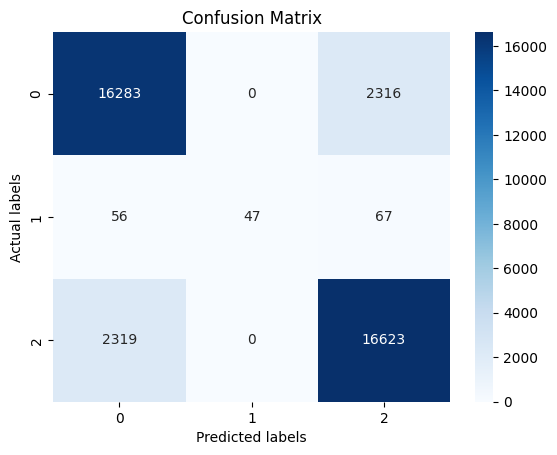

In [98]:
cm = confusion_matrix(y_test, y_pred)
seaborn.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion Matrix')

plt.show()

# 🧬 Modelling
The last model we are going to use is [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). It is a supervised machine learning algorithm typically used for classification tasks. SVC works by mapping data points to a high-dimensional space and then finding the optimal hyperplane that divides the data into two classes. We can see below that it is the best performing model but also the slowest one to train. 

In [138]:
from sklearn.svm import SVC
# clf = SVC(C=5,probability=True)
clf = SVC(C=5)
clf.fit(X_train_vec, y_train)

y_pred = clf.predict(X_test_vec)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:",accuracy)
#Accuracy: 0.8795455738049011

Accuracy: 0.8819737365698368


# 🔬 Evaluation

Confusion Matrix:
[[16392  2268     7]
 [ 2119 16729     5]
 [   34    16   125]]


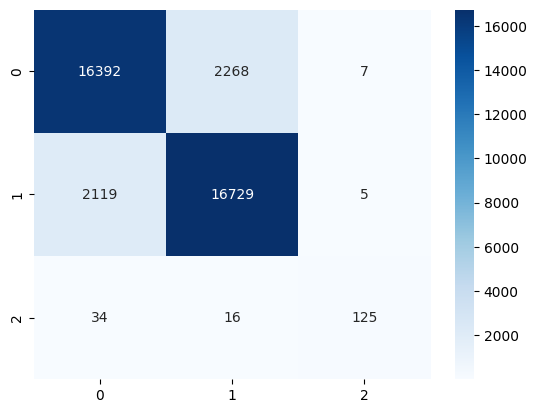

In [139]:
# Make predictions on the test set
y_pred = clf.predict(X_test_vec)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

print("Confusion Matrix:")
print(conf_matrix)

# 🧬 Modelling
Finally, we are going to try to ensemble several models in order to improve the accuracy and performence. We will use the models we trained above.[VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) is an ensemble learning technique in scikit-learn library that combines multiple machine learning models to improve the overall performance of a classification task. It is a meta-estimator that takes a list of machine learning models and combines their predictions using a voting strategy to make a final prediction.There are two types of voting strategies in VotingClassifier:
- Hard Voting: In this strategy, the majority class predicted by the models is taken as the final prediction. This strategy is used for classification tasks.
- Soft Voting: In this strategy, the average of the predicted class probabilities of the models is taken as the final prediction. This strategy is used for classification tasks where the models have a 'predict_proba' method, which returns the class probabilities of the predictions.

For our VotingClassifier we are going to use our LogisticRegressionModelCV, RandomForest and Multinomial Naive Bayes but not our SVC model. The reason for that is that `predict_proba` can be used only if the SVC model is trained with `probability` parameter to be 'True' which increases the training time with hours!

In [109]:
from sklearn.ensemble import VotingClassifier


voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rfc), ('nb', mnb)],
    voting='soft', weights=[1,1,1]
)


voting_clf.fit(X_train_vec, y_train)
y_pred = voting_clf.predict(X_test_vec)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 34.4min remaining: 51.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 34.6min finished


In [111]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8782597161427245


Now we will try to change the weights of the models. We will put 2 for LogisticRegressionCV model because is the best performing one.

In [112]:
from sklearn.ensemble import VotingClassifier

voting_clf_proba = VotingClassifier(
    estimators=[('lr', lr), ('rf', rfc), ('nb', mnb)],
    voting='soft', weights=[2,1,1]
)


voting_clf_proba.fit(X_train_vec, y_train)
y_pred = voting_clf_proba.predict(X_test_vec)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 23.4min remaining: 35.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 23.7min finished


In [113]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8824777821992307


In [114]:
pred = voting_clf_proba.predict_proba(X_test_vec)
predictions = pd.DataFrame(pred, columns=columns.keys())
predictions["truth"] = [ 'neg' if i==0 else 'pos' if i==1 else 'spam' for i in y_test ]
predictions["text"] = X_test.values

for col in columns.keys():
    predictions[col] = predictions[col].apply(lambda x: '{:.2%}'.format(x))

#makes the dataframe look bigger
pd.set_option('display.max_colwidth', 1000)

predictions.sample(10)

,neg,pos,spam,truth,text
19502,4.53%,95.38%,0.09%,pos,the men can slaver over lollo if they like or her lollosshe gave her name to a slang terms for breasts in french but the ladies have an even tastier morsel in the divine gerard philipe who is not only beautiful but can act do not be deterred if your version has no subtitles because in this simple dashing story of love and war in which all is fair they are not needed all you need know is that at the beginning of the film lollobrigida reads philipes palm and tells him he will marry the daughter of the king thereafter the story is quite plain from the gallic gestures and the running jumping and swordplay on the minus side the obviousness of the story and the heavyhanded facetiousness of the tone become somewhat wearying and it is annoying that the french apparently consider themselves too superior to hollywood to bother even attempting the plausibility of its exciting stunts and of course the nonfrenchspeaker misses the occasional bit of oohlala such as virtuous girl i must tell you t...
14754,96.07%,3.93%,0.00%,neg,interferencia starts as unemployed martin sanders andres bagg hears something strange on his phone he hears a mysterious man talking to a prostitute named diana arranging to meet her soon after martin reads a local paper sees the front page story about a prostitute being murdered thinks back to what he heard martin confides in his friends laura virginia lustig aaron oliver kolker but they do not believe him then shortly after the same thing happens again the phone call the man the prostitute her death reported in the papers martin decides he has to find the killer put a stop to his killing spree but who is it this argentinian production that was apparently shot in just eight days why so long on a budget of about why so much was written directed by sergio esquenazi i cannot believe some of the glowing comments interferencia has on the imdb out of user ratings as i write this of them rate this pile of crap out of i am sorry but there is no way anyone should be giving a f...
29934,95.16%,4.74%,0.10%,neg,i do not have much to say about this movie it could have been a wonderful tourdeforce for peter sellers but it is one of the most tragic misfires in movie history that it was sellers final movie makes it all the more painful the terrible screenplay direction and shockingly wooden performances all come dreadfully together to make this one of the most unwatchably awful movies ever made i wish so much that i could find even a snicker or a chuckle buried somewhere in this pile of putrid blubber but it is a lifeless humorless disaster the truth hurts peter why could not you have stopped at being there
33524,7.50%,92.45%,0.05%,pos,if you like rap or hiphop watch this movie although it is funny if you do not get the references as a straight comedy have not seen much of the much hyped cb but what i did see did not have the heart that this little stormer has have not heard from the people involved since which is a surprise the film is very similar to spinal tap which is no bad thing and i think a lot of the dialogue while priceless in tap is funnier here probably because i am more into rap than rock theses days so my own judgment does cloud that point the rap songs are funny as hell and it is basically spot the reference for most of the film not all of them are inyourface which means the physical comedy and the oneliners get priority over the takeoffs great fun one to watch twice if there ever was a movie
17512,13.94%,86.00%,0.06%,pos,i do not believe this was an acting challenge for richard harris this was an uncomplicated plot yet interesting it is a good movie to watch when you do not want to do a lot of thinking just want to be told a simple story the canadian scenery was breathtaking the beautiful fall shots alone made the picture worth seeing
5591,1.81%,98.19%,0.00%,pos,if one overlooks the technical problems of this early sound movie such as the sound quality and the occ

In [115]:
message = "I hate the movie"
message_vectorized = vectorizer.transform([message]).toarray()
inference = voting_clf_proba.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = voting_clf_proba.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)

     neg    pos  spam
0  52.81  46.17  1.02
Predicted sentiment: neg


In [116]:
message = """After hearing all the hype, I was really excited to see this movie. But from the very beginning, I could tell that something was off. The pacing was slow and plodding, and the characters felt wooden and one-dimensional.

As the movie went on, I found myself getting more and more frustrated with the plot. It was convoluted and confusing, with too many twists and turns that didn't seem to add up to anything. And just when I thought things couldn't get any worse, the ending came out of nowhere and left me feeling completely unsatisfied.

To make matters worse, the acting was subpar at best. The lead actor was completely miscast, and his performance was flat and unconvincing. And don't even get me started on the supporting cast, who were equally unremarkable.

Overall, I was really disappointed with this movie. It had all the makings of a great film, but instead it fell completely flat. I wouldn't recommend it to anyone, and I certainly won't be watching it again anytime soon because I hate it."""
message_vectorized = vectorizer.transform([message]).toarray()
inference = voting_clf_proba.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = voting_clf_proba.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)

     neg    pos  spam
0  88.26  11.71  0.02
Predicted sentiment: neg


In [117]:
message = "This movie was a mixed bag. While some of the performances were strong and the production value was high, the plot was convoluted and difficult to follow. The ending left me feeling unsatisfied and confused. Overall, I can't say whether I liked it or not."
message_vectorized = vectorizer.transform([message]).toarray()
inference = voting_clf_proba.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = voting_clf_proba.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)


     neg    pos  spam
0  36.47  62.98  0.55
Predicted sentiment: pos


In [118]:
message = "HEY! CHECK OUT MY NEW MIXTAPE RIGHT NOW"
message_vectorized = vectorizer.transform([message]).toarray()
inference = voting_clf_proba.predict_proba(message_vectorized)[0]
result = pd.DataFrame(inference.reshape(1,-1), columns=['neg', 'pos', 'spam']) * 100
result = result.round(2)
print(result)
predicted_label = voting_clf_proba.predict(message_vectorized)[0]
predicted_sentiment = {0: 'neg', 1: 'pos', 2: 'spam'}[predicted_label]
print("Predicted sentiment:", predicted_sentiment)


    neg   pos   spam
0  7.33  7.53  85.14
Predicted sentiment: spam


In [119]:
text = "The movie was okay. It could have been better for sure but for 2023 it works."   # Sample text
tokens = word_tokenize(text)
# stop_words = set(stopwords.words('english'))
tokens = [token for token in tokens if token.lower() not in stop_words]

r = Rake()
r.extract_keywords_from_text(text)
keywords = r.get_ranked_phrases()

resultDf = pd.DataFrame(columns=['Keyword', 'Predicted Sentiment', 'Negative Probability', 'Positive Probability', 'Spam Probability'])

for keyword in keywords:
    keyword_vectorized = vectorizer.transform([keyword]).toarray()
    inference = voting_clf_proba.predict_proba(keyword_vectorized)[0].round(3)
    predicted_label = voting_clf_proba.predict(keyword_vectorized)[0]
    if predicted_label == 0:
        predicted_sentiment = 'neg'
    elif predicted_label == 1:
        predicted_sentiment = 'pos'
    else:
        predicted_sentiment = 'spam'
    row = {'Keyword': keyword, 'Predicted Sentiment': predicted_sentiment, 'Negative Probability': inference[0], 'Positive Probability': inference[1], 'Spam Probability': inference[2]}
    resultDf = pd.concat([resultDf, pd.DataFrame(row, index=[0])], ignore_index=True)

resultDf


,Keyword,Predicted Sentiment,Negative Probability,Positive Probability,Spam Probability
0,works,pos,0.355,0.594,0.051
1,sure,pos,0.481,0.490,0.029
2,okay,neg,0.549,0.386,0.066
3,movie,neg,0.534,0.455,0.011
4,could,neg,0.396,0.389,0.216
5,better,neg,0.556,0.413,0.031
6,2023,neg,0.396,0.389,0.216


In [120]:
text = """After months of anticipation, I finally watched the highly acclaimed movie that everyone has been raving about. The film was a sweeping epic, with a sprawling cast of characters and a complex, multi-layered storyline. The cinematography was stunning, with breathtaking landscapes and intricate set designs that transported me to another world.

At the heart of the film was a poignant love story between the two main characters, played by two incredibly talented actors who had an undeniable chemistry on screen. Their performances were riveting and nuanced, conveying a range of emotions from joy and love to heartbreak and despair.

The supporting cast was equally impressive, with standout performances from several veteran actors who brought depth and nuance to their roles. The dialogue was smart and snappy, with clever quips and one-liners that kept me engaged and entertained throughout the film.

While the film was undeniably a triumph of filmmaking, there were a few missteps along the way. Some of the plot points felt rushed or underdeveloped, leaving me with more questions than answers. Additionally, the film's pacing could have been tighter, with some scenes feeling overly long or dragging on without purpose.

Despite these minor flaws, the film was a tour de force of cinema, and one that will surely be remembered for years to come. I left the theater feeling moved and inspired, eager to revisit the film and uncover new layers and meanings in its intricate story."""  # Sample text

tokens = word_tokenize(text)
# stop_words = set(stopwords.words('english'))
tokens = [token for token in tokens if token.lower() not in stop_words]

r = Rake(min_length=1, max_length=1)
r.extract_keywords_from_text(text)
keywords = r.get_ranked_phrases()

resultDf = pd.DataFrame(columns=['Keyword', 'Predicted Sentiment', 'Negative Probability', 'Positive Probability', 'Spam Probability'])

for keyword in keywords:
    keyword_vectorized = vectorizer.transform([keyword]).toarray()
    inference = voting_clf_proba.predict_proba(keyword_vectorized)[0].round(3)
    predicted_label = voting_clf_proba.predict(keyword_vectorized)[0]
    if predicted_label == 0:
        predicted_sentiment = 'neg'
    elif predicted_label == 1:
        predicted_sentiment = 'pos'
    else:
        predicted_sentiment = 'spam'
    row = {'Keyword': keyword, 'Predicted Sentiment': predicted_sentiment, 'Negative Probability': inference[0], 'Positive Probability': inference[1], 'Spam Probability': inference[2]}
    resultDf = pd.concat([resultDf, pd.DataFrame(row, index=[0])], ignore_index=True)

resultDf.sample(10)

,Keyword,Predicted Sentiment,Negative Probability,Positive Probability,Spam Probability
58,characters,neg,0.499,0.486,0.015
26,months,pos,0.418,0.475,0.107
32,kept,neg,0.494,0.473,0.033
45,everyone,neg,0.396,0.389,0.216
55,come,neg,0.464,0.446,0.090
11,screen,pos,0.484,0.494,0.021
6,tighter,neg,0.547,0.256,0.197
52,despair,pos,0.294,0.592,0.114
24,nuance,pos,0.339,0.483,0.178
20,performances,pos,0.397,0.582,0.021


In [135]:
# # exporting the model as a file

# import pickle
# with open('vectorizer.pkl', 'wb') as f:
#     pickle.dump(vectorizer, f)